In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
from random import choice
from random import sample
from itertools import combinations
import random

import metis # lulz

# TODO:
# Split computing nodes and finding the best route
# BFS for each graph time
# 100 landmarks

## Choosing random nodes for landmark

In [2]:
def generate_rng_landmark_list(graph, num_landmarks=20):
    """
    Generate a list of random landmarks from the given graph.

    Parameters:
    - graph: NetworkX graph
    - num_landmarks: Number of landmarks to generate (default is 20)
    Returns:
    - landmark_list: List of random landmarks
    """
    landmark_list = []

    for i in range(num_landmarks):
        random_node = choice(list(graph.nodes()))
        if random_node not in landmark_list:
            landmark_list.append(random_node)

    return landmark_list


## Calculating each node's degree

In [3]:
def calculate_degree_centrality(graph, N=20, check_neighbors=True):
    """
    Get the top nodes with the highest degree in the graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to retrieve (default is 20)

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    selected_nodes = []
    degree_centrality = {}

    top_nodes_degree = [node for node in sorted(graph.nodes(), key=graph.degree, reverse=True)]

    if check_neighbors:
        for node in top_nodes_degree:
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                degree_centrality[node] = graph.degree(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(top_nodes_degree):
            selected_nodes.append(node)
            degree_centrality[node] = graph.degree(node)
            if i + 1 == N:
                break

    return degree_centrality

# # Print the results
# print("Without checking neighbors:")
# print(calculate_degree_centrality(G_dblp, N=20, check_neighbors=False))

# print("\nChecking neighbors:")
# print(calculate_degree_centrality(G_dblp, N=20, check_neighbors=True))


## Calculate each's node closeness centrality (approximation)

In [4]:
def approximate_closeness_centrality(graph, num_seeds):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the closeness centrality dictionary
    approx_closeness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node
    for seed_node in seed_nodes:
        distances = nx.single_source_shortest_path_length(graph, seed_node)
        for node, distance in distances.items():
            approx_closeness_centrality[node] += distance

    # Normalize the closeness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_closeness_centrality[node] /= num_seeds

    return approx_closeness_centrality

In [5]:
def calculate_closeness_centrality(graph, N=20, num_seeds=20, check_neighbors=True):
    """
    Calculate the approximate closeness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - N: Number of top nodes to select (default is 20)
    - num_seeds: Number of random seed nodes to use (default is 20)
    - check_neighbors: A boolean indicating whether to check the neighborhood of previously selected nodes (default is True)

    Returns:
    - closeness_centrality: Dictionary of nodes with their closeness centrality values
    """
    # Calculate approximate closeness centrality for each node
    approx_closeness_centrality = approximate_closeness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by closeness centrality
    sorted_nodes_closeness = [node for node in sorted(approx_closeness_centrality, key=approx_closeness_centrality.get) if approx_closeness_centrality[node] > 0]

    if check_neighbors:
        for node in sorted_nodes_closeness:
            # Check if the node is not in the neighborhood of any previously selected nodes
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(sorted_nodes_closeness):
            selected_nodes.append(node)
            if i + 1 == N:
                break

    # Create a dictionary of nodes with their closeness centrality values
    closeness_centrality = {node: approx_closeness_centrality[node] for node in selected_nodes}

    return closeness_centrality

# # example
# print("Without checking neighbors:")
# print(calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=False))
# print("\nChecking neighbors:")
# print(calculate_closeness_centrality(G_dblp, N=20, num_seeds=20, check_neighbors=True))

## Calculate each's node betweeness centrality (approximation)

In [6]:
def approximate_betweenness_centrality(graph, num_seeds=20):
    # Select a sample of random seed nodes
    seed_nodes = random.sample(list(graph.nodes()), num_seeds)

    # Initialize the betweenness centrality dictionary
    approx_betweenness_centrality = {node: 0.0 for node in graph.nodes()}

    # Perform BFS computations from each seed node and accumulate dependencies
    for seed_node in seed_nodes:
        paths = nx.single_source_shortest_path(graph, source=seed_node)
        dependencies = {node: 0 for node in graph.nodes()}

        for path in paths.values():
            for node in path[1:-1]:  # Exclude the source and target nodes
                dependencies[node] += 1

        # Accumulate betweenness centrality using dependencies
        for node in graph.nodes():
            if node != seed_node:
                approx_betweenness_centrality[node] += dependencies[node]

    # Normalize the betweenness centrality by the number of seed nodes
    for node in graph.nodes():
        approx_betweenness_centrality[node] /= num_seeds

    return approx_betweenness_centrality


In [7]:
def calculate_betweenness_centrality(graph, num_seeds=20, N=20, check_neighbors=True):
    """
    Calculate the approximate betweenness centrality for a given graph.

    Parameters:
    - graph: NetworkX graph
    - num_seeds: Number of random seed nodes to use (default is 20)
    - N: Number of top nodes to select (default is 20)
    - check_neighbors: A boolean indicating whether to check the neighborhood of previously selected nodes (default is True)

    Returns:
    - betweenness_centrality: Dictionary of nodes with their betweenness centrality values
    """
    # Calculate approximate betweenness centrality for each node
    approx_betweenness_centrality = approximate_betweenness_centrality(graph, num_seeds)

    # Initialize the list of selected nodes
    selected_nodes = []

    # Get the nodes sorted by betweenness centrality
    sorted_nodes_betweenness = [node for node in sorted(approx_betweenness_centrality, reverse=True, key=approx_betweenness_centrality.get) if approx_betweenness_centrality[node] > 0]

    if check_neighbors:
        for node in sorted_nodes_betweenness:
            # Check if the node is not in the neighborhood of any previously selected nodes
            if not any(prev_node in graph.neighbors(node) for prev_node in selected_nodes):
                selected_nodes.append(node)
                if len(selected_nodes) == N:
                    break
    else:
        for i, node in enumerate(sorted_nodes_betweenness):
            selected_nodes.append(node)
            if i + 1 == N:
                break

    # Create a dictionary of nodes with their betweenness centrality values
    betweenness_centrality = {node: approx_betweenness_centrality[node] for node in selected_nodes}

    return betweenness_centrality

# # Example usage:
# betweenness_centrality_true = calculate_betweenness_centrality(G_dblp, num_seeds=20, N=20, check_neighbors=True)
# print(betweenness_centrality_true)

# betweenness_centrality_false = calculate_betweenness_centrality(G_dblp, num_seeds=20, N=20, check_neighbors=False)
# print(betweenness_centrality_false)

# Hybrid nodes

In [8]:
# 1/3 of each strategy

def calculate_hybrid_nodes(graph, num_nodes, num_seeds=20, check_neighbors=False):
    """
    Calculates the hybrid nodes based on closeness centrality, degree centrality, and betweenness centrality.

    Parameters:
    graph (networkx.Graph): The input graph.
    num_nodes (int): The number of hybrid nodes to calculate.
    num_seeds (int, optional): The number of seeds to use for centrality calculations. Default is 20.
    check_neighbors (bool, optional): Whether to check the neighbors of the seeds. Default is False.

    Returns:
    list: The list of hybrid nodes.

    Raises:
    None

    """

    closeness_landmarks = calculate_closeness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    closeness_nodes = set(closeness_landmarks.keys())
    top_closeness_nodes = list(closeness_nodes)[:num_nodes]

    degree_landmarks = calculate_degree_centrality(graph, num_nodes, check_neighbors=check_neighbors)
    degree_nodes = set(degree_landmarks.keys()) - set(top_closeness_nodes)
    top_degree_nodes = list(degree_nodes)[:num_nodes]

    betweenness_landmarks = calculate_betweenness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    betweenness_nodes = set(betweenness_landmarks.keys()) - set(top_closeness_nodes) - set(top_degree_nodes)
    top_betweenness_nodes = list(betweenness_nodes)[:num_nodes]

    top_nodes_hybrid = top_closeness_nodes + top_degree_nodes + top_betweenness_nodes
    return top_nodes_hybrid

In [9]:
# half of each strategy (closeness, degree)
def calculate_hybrid_nodes_closeness_degree(graph, num_nodes, num_seeds=20, check_neighbors=False):
    """
    Calculates the hybrid nodes based on closeness centrality and degree centrality.

    Parameters:
    graph (networkx.Graph): The input graph.
    num_nodes (int): The number of hybrid nodes to calculate.
    num_seeds (int, optional): The number of seeds to use for centrality calculations. Default is 20.
    check_neighbors (bool, optional): Whether to check the neighbors of the seeds. Default is False.

    Returns:
    list: The list of hybrid nodes.

    Raises:
    None

    """

    closeness_landmarks = calculate_closeness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    closeness_nodes = set(closeness_landmarks.keys())
    top_closeness_nodes = list(closeness_nodes)[:num_nodes]

    degree_landmarks = calculate_degree_centrality(graph, num_nodes, check_neighbors=check_neighbors)
    degree_nodes = set(degree_landmarks.keys()) - set(top_closeness_nodes)
    top_degree_nodes = list(degree_nodes)[:num_nodes]

    top_nodes_hybrid = top_closeness_nodes + top_degree_nodes
    return top_nodes_hybrid

In [10]:
# half of each strategy (closeness, betweenness)
def calculate_hybrid_nodes_closeness_betweenness(graph, num_nodes, num_seeds=20, check_neighbors=False):
    """
    Calculates the hybrid nodes based on closeness centrality and betweenness centrality.

    Parameters:
    graph (networkx.Graph): The input graph.
    num_nodes (int): The number of hybrid nodes to calculate.
    num_seeds (int, optional): The number of seeds to use for centrality calculations. Default is 20.
    check_neighbors (bool, optional): Whether to check the neighbors of the seeds. Default is False.

    Returns:
    list: The list of hybrid nodes.

    Raises:
    None

    """

    num_nodes = int(num_nodes / 2)  # Adjust for two centrality measures

    closeness_landmarks = calculate_closeness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    closeness_nodes = set(closeness_landmarks.keys())
    top_closeness_nodes = list(closeness_nodes)[:num_nodes]

    betweenness_landmarks = calculate_betweenness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    betweenness_nodes = set(betweenness_landmarks.keys()) - set(top_closeness_nodes)
    top_betweenness_nodes = list(betweenness_nodes)[:num_nodes]

    top_nodes_hybrid = top_closeness_nodes + top_betweenness_nodes
    return top_nodes_hybrid

In [11]:
# haf of each strategy (degree, betweenness)
def calculate_hybrid_nodes_degree_betweenness(graph, num_nodes, num_seeds=20, check_neighbors=False):
    """a
    Calculates the hybrid nodes based on degree centrality and betweenness centrality.

    Parameters:
    graph (networkx.Graph): The input graph.
    num_nodes (int): The number of hybrid nodes to calculate.
    num_seeds (int, optional): The number of seeds to use for centrality calculations. Default is 20.
    check_neighbors (bool, optional): Whether to check the neighbors of the seeds. Default is False.

    Returns:
    list: The list of hybrid nodes.

    Raises:
    None

    """

    num_nodes = int(num_nodes / 2)  # Adjust for two centrality measures

    degree_landmarks = calculate_degree_centrality(graph, num_nodes, check_neighbors=check_neighbors)
    degree_nodes = set(degree_landmarks.keys())
    top_degree_nodes = list(degree_nodes)[:num_nodes]

    betweenness_landmarks = calculate_betweenness_centrality(graph, N=num_nodes, num_seeds=num_seeds, check_neighbors=check_neighbors)
    betweenness_nodes = set(betweenness_landmarks.keys()) - set(top_degree_nodes)
    top_betweenness_nodes = list(betweenness_nodes)[:num_nodes]

    top_nodes_hybrid = top_degree_nodes + top_betweenness_nodes
    return top_nodes_hybrid

# Partitioning

In [12]:
def partition_graph_func(graph, num_partitions):
    """
    Partition a graph using METIS.

    Parameters:
    - graph: NetworkX graph
    - num_partitions: Number of partitions

    Returns:
    - partitions: List of sets representing the node partitions
    - edge_cut: Number of edges cut during partitioning
    """

    # Perform METIS graph partitioning
    (edge_cut, parts) = metis.part_graph(graph, nparts=num_partitions)

    # Create a list of sets, where each set contains the nodes in a partition
    partition_sets = [set() for _ in range(num_partitions)]
    for node, partition in enumerate(parts):
        partition_sets[partition].add(node)

    return partition_sets, edge_cut

# Degree centralities for each partion

In [13]:
# # lowest centralities in each partition
# degree_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     degree_centrality = calculate_degree_centrality(partition_graph, N=20)
#     degree_centralities[f"part{i}"] = degree_centrality

# print(degree_centralities)

In [14]:
# # highest node for each partition
# for part, centrality in degree_centralities.items():
#     highest_centrality_node = max(centrality, key=centrality.get)
#     highest_centrality_value = centrality[highest_centrality_node]
#     print(f"The highest degree centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")

# Closeness centralities for each partion

In [15]:
# # lowest centralities in each partition
# closeness_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     closeness_centrality = calculate_closeness_centrality(partition_graph, N=20, num_seeds=20)
#     closeness_centralities[f"part{i}"] = closeness_centrality

# print(closeness_centralities)

In [16]:
# # lowest node for each partition
# for part, centrality in closeness_centralities.items():
#     lowest_centrality_node = min(centrality, key=centrality.get)
#     lowest_centrality_value = centrality[lowest_centrality_node]
#     print(f"The lowest closeness centrality in {part} is {lowest_centrality_value} for node {lowest_centrality_node}")


# Betweness centralities for each partion

In [17]:
# # highest centralities in each partition
# betweenness_centralities = {}
# for i, partition in enumerate(partition_sets):
#     partition_graph = G_dblp.subgraph(partition)
#     betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=20, num_seeds=20)
#     betweenness_centralities[f"part{i}"] = betweenness_centrality

# print(betweenness_centralities)

In [18]:
# # highest node for each partition
# for part, centrality in betweenness_centralities.items():
#     highest_centrality_node = max(centrality, key=centrality.get)
#     highest_centrality_value = centrality[highest_centrality_node]
#     print(f"The highest betweenness centrality in {part} is {highest_centrality_value} for node {highest_centrality_node}")


# Border

In [19]:
def calculate_degree_centrality_all(graph):
    """
    Calculate the degree centrality for all nodes in the graph.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - degree_centrality: Dictionary of nodes with their degree centrality values
    """
    degree_centrality = {}

    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node)

    return degree_centrality


def calculate_border_degree_nodes(graph, num_partitions=20):
    """
    Calculate the degree centrality for each partition in the graph.

    Parameters:
    - graph: NetworkX graph
    - partition_sets: List of sets representing the node partitions

    Returns:
    - degree_centrality_partitions: Dictionary of partitions with their degree centrality values
    """
    degree_centrality = calculate_degree_centrality_all(graph)
    partition_sets, edge_cut = partition_graph_func(graph, num_partitions)
    degree_centrality_partitions = {}

    for i, partition in enumerate(partition_sets):
        partition_degree_centrality = {node: degree_centrality[node] for node in partition if node in degree_centrality}
        degree_centrality_partitions[i] = partition_degree_centrality

    return degree_centrality_partitions


def get_highest_degree_nodes_border(graph, num_partitions=20):
    """
    Get the highest degree nodes for each partition in the graph.

    Parameters:
    - graph: NetworkX graph
    - num_partitions: Number of partitions

    Returns:
    - highest_degree_nodes: Dictionary of nodes with their highest degree value
    """
    test_doc = calculate_border_degree_nodes(graph, num_partitions)
    highest_degree_nodes = {}

    for partition, degree_centrality in test_doc.items():
        highest_degree_node = max(degree_centrality, key=degree_centrality.get)
        highest_degree_value = degree_centrality[highest_degree_node]
        highest_degree_nodes[highest_degree_node] = highest_degree_value

    return highest_degree_nodes

# get_highest_degree_nodes_border(G_dblp, num_partitions=20)



In [20]:
# highest_degree_nodes = {}

# for partition, centrality in degree_centrality_partitions.items():
#     highest_degree_node = max(centrality, key=centrality.get)
#     highest_degree = centrality[highest_degree_node]
#     highest_degree_nodes[partition] = f"Node: {highest_degree_node} Degree: {highest_degree}"

# highest_degree_nodes


# Short distance estimation

## Random landmark selection

In [21]:
import random

def generate_random_node_pairs(graph, number_pairs=1):
    """
    Generate a specified number of random pairs of nodes from the given graph.

    Parameters:
    - graph: NetworkX graph
    - number_pairs: Number of random pairs to generate (default is 1)

    Returns:
    - node_pairs: List of tuples, each containing two randomly chosen nodes
    """

    # Get the list of nodes in the graph
    nodes = list(graph.nodes)

    # Ensure the graph has at least two nodes
    if len(nodes) < 2:
        raise ValueError("Graph must have at least two nodes.")

    # Generate random node pairs
    node_pairs = [tuple(random.sample(nodes, 2)) for _ in range(number_pairs)]

    return node_pairs

# # Example:
# random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=5)
# print("Random Node Pairs:", random_node_pairs)


In [22]:
def estimate_shortest_path(graph, source, target, landmarks):
    """
    Estimate the shortest path distance between two nodes in the graph using landmarks.

    Parameters:
    - graph: NetworkX graph
    - source: Source node
    - target: Target node
    - landmarks: List of landmarks
    """
    # Function to estimate shortest path distance between source and target using landmarks
    
    # Calculate distances from source and target to landmarks
    source_distances = {landmark: nx.shortest_path_length(graph, source=source, target=landmark) for landmark in landmarks}
    target_distances = {landmark: nx.shortest_path_length(graph, source=target, target=landmark) for landmark in landmarks}
    
    # Estimate shortest path distance using the landmark distances
    estimation = min(source_distances[landmark] + nx.shortest_path_length(graph, source=landmark, target=target)
                     for landmark in landmarks)
    
    return estimation

In [23]:
def calculate_exact_shortest_path(graph, source, target):
    """
    Calculate the exact shortest path distance between a source and target node in a graph.
    
    Parameters:
    - graph: NetworkX graph object
    - source: source node
    - target: target node
    
    Returns:
    - shortest_path_distance: shortest path distance between the source and target nodes, or None if no path exists
    """
    try:
        shortest_path_distance = nx.shortest_path_length(graph, source, target)
        return shortest_path_distance
    except nx.NetworkXNoPath:
        return None

# Estimation quallity - using this formula


In [24]:
def diff_exact_estimate(exact_shortest_paths, estimate_shortest_paths):
    """
    Calculates the average difference between exact shortest paths and estimated shortest paths.

    Args:
        exact_shortest_paths (dict): A dictionary containing exact shortest paths.
        estimate_shortest_paths (dict): A dictionary containing estimated shortest paths.

    Returns:
        float: The average difference between exact shortest paths and estimated shortest paths.
    """
    # Calculate the differences between exact and estimated shortest paths
    differences = []
    exact_shortest_paths = exact_shortest_paths.values()
    estimate_shortest_paths = estimate_shortest_paths.values()
    for distance_exact in exact_shortest_paths:
        for distance_est in estimate_shortest_paths:
            value = (abs(distance_est - distance_exact)) / distance_exact # the formula
            differences.append(value)
    
    # Calculate the average difference
    average = sum(differences) / len(differences)
    return average

# DBLP dataset

In [25]:
# grap init
G_dblp = nx.Graph()


# dblp.tsv
with open('data/dblp/com-dblp/out.com-dblp.tsv', 'r') as file:
    for line in file:
        source, target = line.strip().split(' ')
        G_dblp.add_edge(int(source), int(target))

num_edges = G_dblp.number_of_edges()
num_nodes = G_dblp.number_of_nodes()


print("number of directed edges in dblp.tsv:", num_edges)
print("number of directed nodes in dblp.tsv:", num_nodes)
print(nx.is_connected(G_dblp))


number of directed edges in dblp.tsv: 1049866
number of directed nodes in dblp.tsv: 317080
True


In [26]:
# Parameters
num_seeds = 200
number_partitions = 102
num_landmarks = 102
random_seed = 69  

# Set the seed for the random number generator
random.seed(random_seed)

# Partition and generating random pairs for DBLP
random_node_pairs = generate_random_node_pairs(G_dblp, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_dblp, number_partitions)

### Exact shortest path

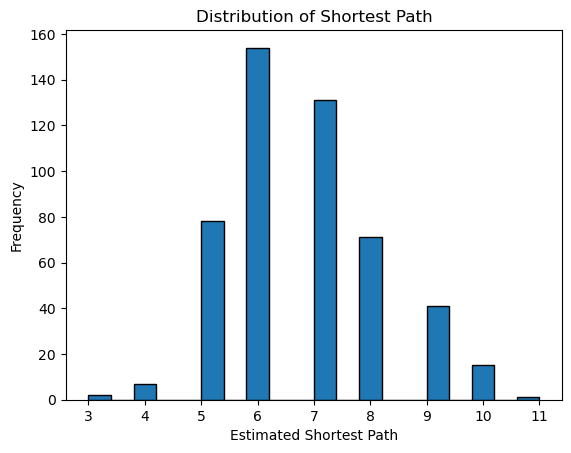

In [27]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_dblp, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())
# print(exact_shortest_paths)

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path')
plt.show()

### Random Landmarks DBLP


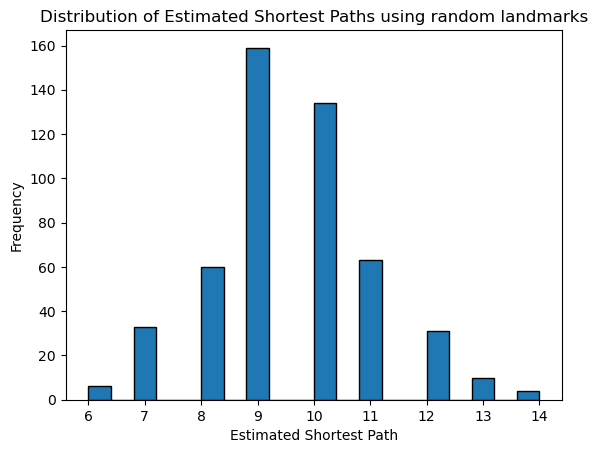

0.4915891808079089


In [28]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_dblp,num_landmarks)

# Calculate estimation of shortest paths between each pair using landmarks
estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))





### Degree landmarks DBLP

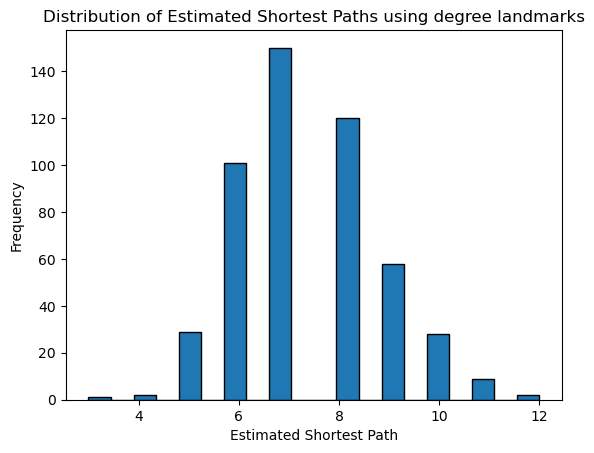

0.2584370512264634


In [29]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_dblp, num_landmarks, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness centrality landmarks DBLP

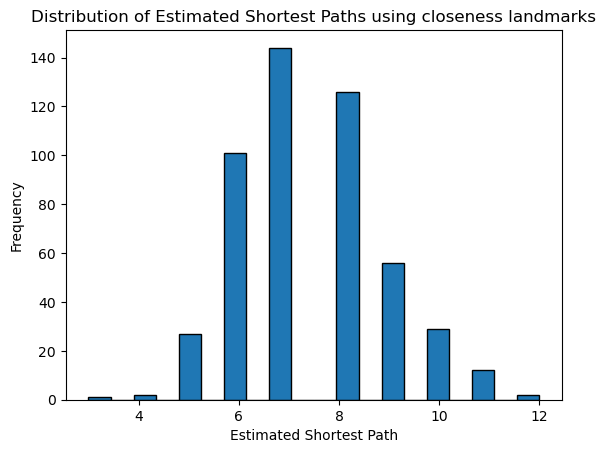

0.2623372354977405


In [30]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_dblp, num_landmarks, num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness landmarks DBLP


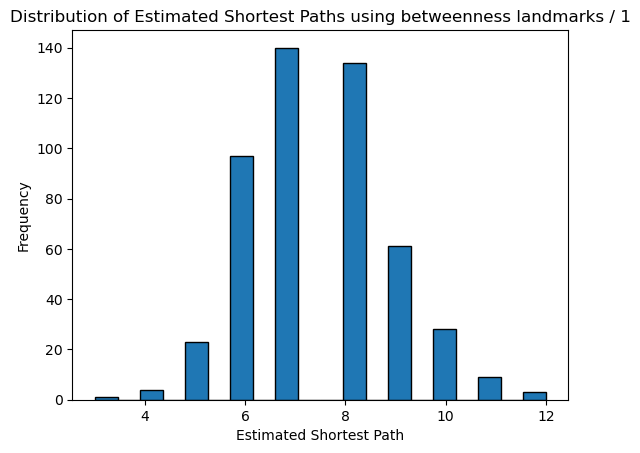

0.2640425639248726


In [31]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_dblp, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Each node in graph to the landmark DBLP

In [32]:
# # Select landmarks
# betweenness_landmarks = calculate_betweenness_centrality(G_dblp, num_landmarks , num_seeds=20, check_neighbors=False)

# # Calculate estimation of shortest paths from each node to each landmark
# estimated_shortest_paths = {}

# for node in G_dblp.nodes():
#     shortest_paths_to_landmarks = []
#     for landmark in betweenness_landmarks.keys():
#         estimation = estimate_shortest_path(G_dblp, node, landmark, betweenness_landmarks)
#         shortest_paths_to_landmarks.append(estimation)
#     # Store the minimum value of the paths to the landmarks
#     estimated_shortest_paths[node] = np.min(shortest_paths_to_landmarks)

# # Get the list of estimated shortest paths
# estimations = list(estimated_shortest_paths.values())

# # Plot the distribution
# plt.hist(estimations, bins=20, edgecolor='black')
# plt.xlabel('Estimated Shortest Path')
# plt.ylabel('Frequency')
# plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
# plt.show()

# print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks / 1 DBLP

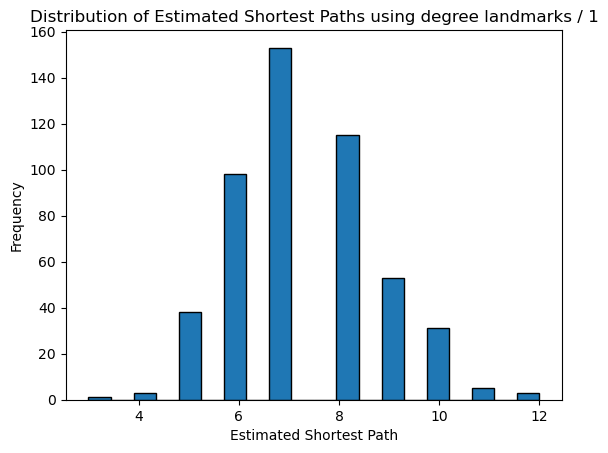

0.2562895518036709


In [33]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_dblp, num_landmarks, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness landmarks / 1 DBLP

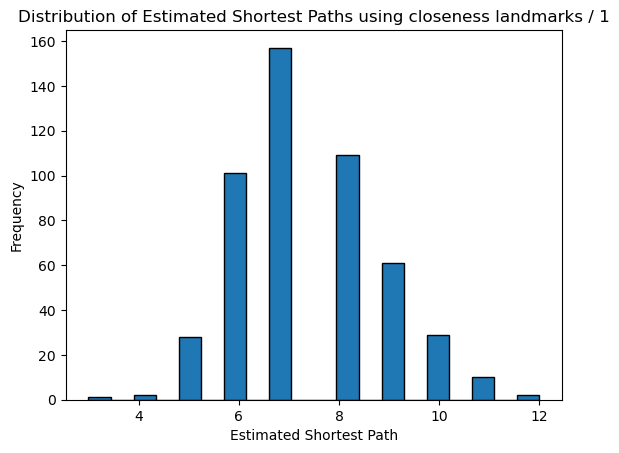

0.2593796411254566


In [34]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_dblp, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Betweenness landmarks / 1 DBLP

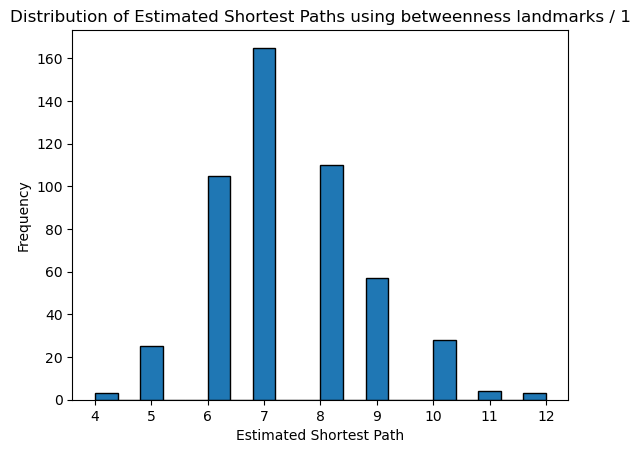

0.2512115277055443


In [35]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_dblp, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree / P DBLP

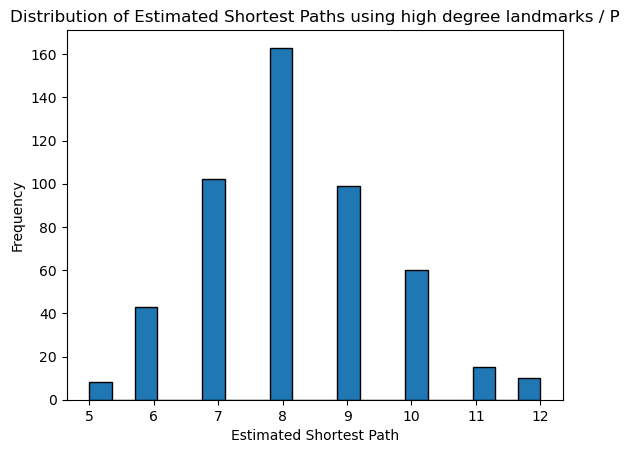

0.3243133108223402


In [36]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Closeness / P DBLP

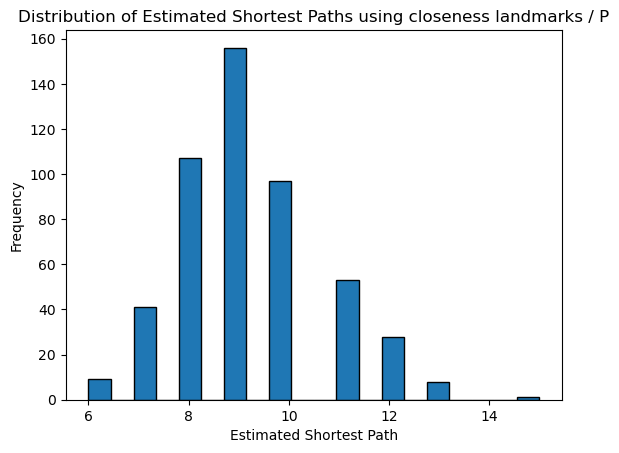

0.44773756464628417


In [37]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness / P DBLP

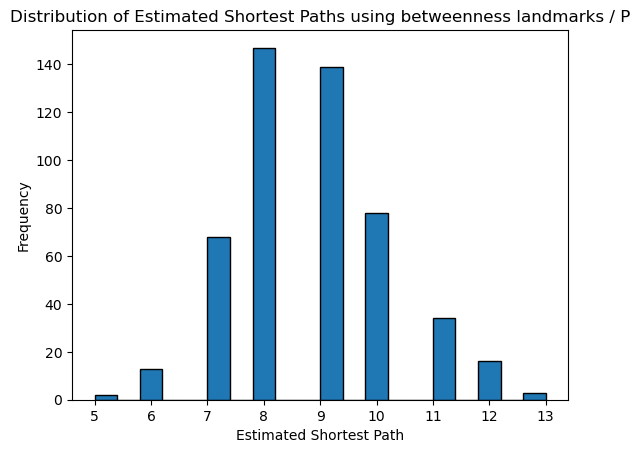

0.3864475717170218


In [38]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_dblp, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Border / P DBLP

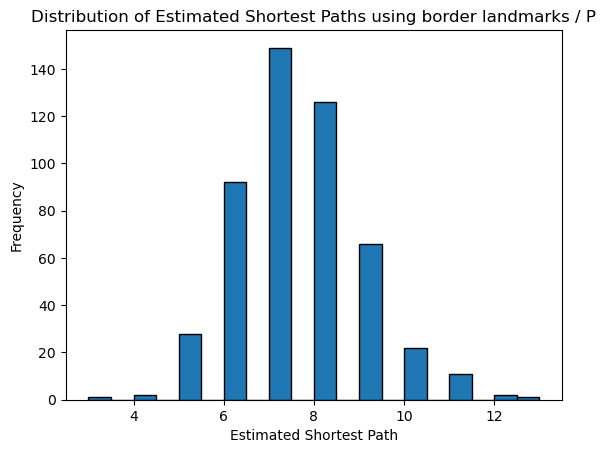

0.2627118380951597


In [39]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_dblp, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid strategy (1/3 top nodes for each strategy) DBLP

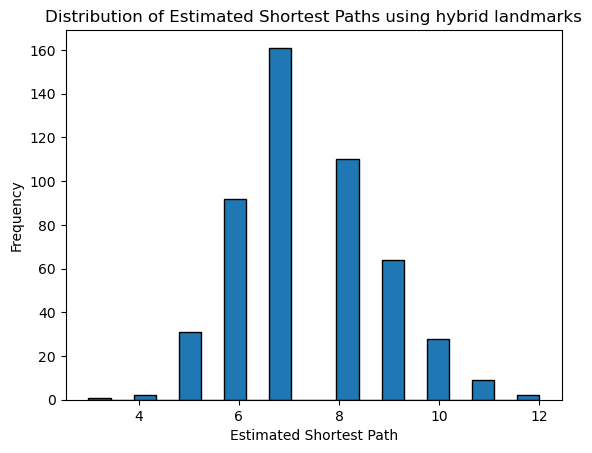

0.25985167878780246


In [40]:
hybrid_landmarks = calculate_hybrid_nodes(G_dblp, int(num_landmarks / 3)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 - Closeness + Degree

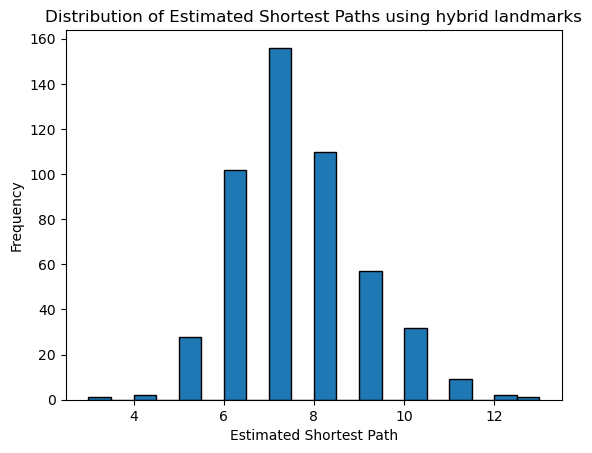

0.26058954603165685


In [41]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_degree(G_dblp, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 - Closeness + Betweenness

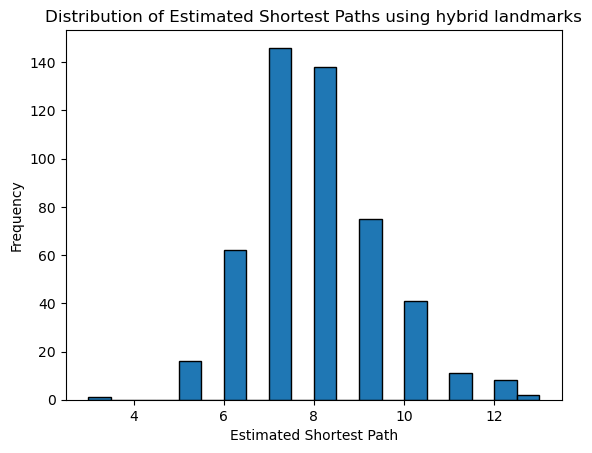

0.2919494330445917


In [42]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_betweenness(G_dblp, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 - Degree+ Betweenness

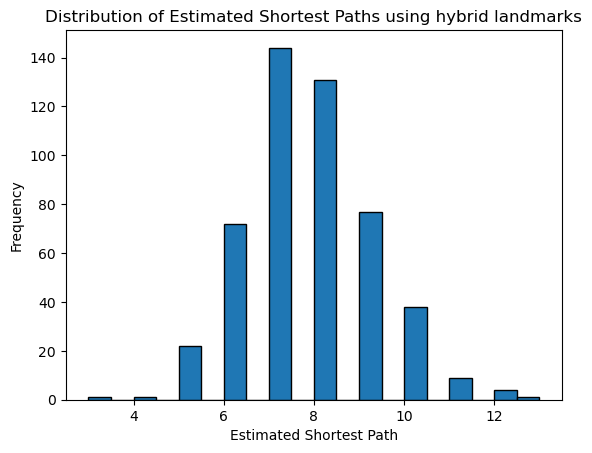

0.2808053431456211


In [43]:
hybrid_landmarks = calculate_hybrid_nodes_degree_betweenness(G_dblp, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_dblp, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

# Twitch dataset

In [44]:
# Read the CSV file into a DataFrame
file_path = 'data/twitch_gamers/large_twitch_edges.csv'
df = pd.read_csv(file_path)

# Initialize the graph
G_twitch = nx.Graph()

# Add edges from the DataFrame
G_twitch.add_edges_from(df.values)

# Get the number of edges and nodes
num_edges = G_twitch.number_of_edges()
num_nodes = G_twitch.number_of_nodes()

print("Number of undirected edges:", num_edges)
print("Number of undirected nodes:", num_nodes)
print(nx.is_connected(G_twitch))


Number of undirected edges: 6797557
Number of undirected nodes: 168114
True


In [45]:
# Parameters for petser

num_seeds = 200
number_partitions = 102
num_landmarks = 102
random_seed = 69  

# Set the seed for the random number generator
random.seed(random_seed)
random_node_pairs = generate_random_node_pairs(G_twitch, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_twitch, number_partitions)

### Exact paths TWITCH

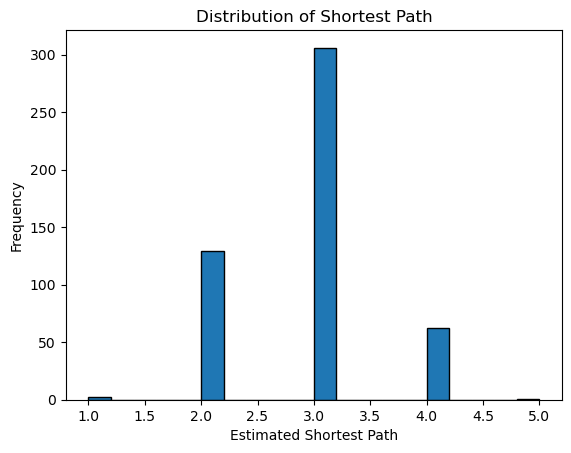

In [46]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_twitch, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())
# print(exact_shortest_paths)

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path')
plt.show()

### Random Landmarks TWITCH

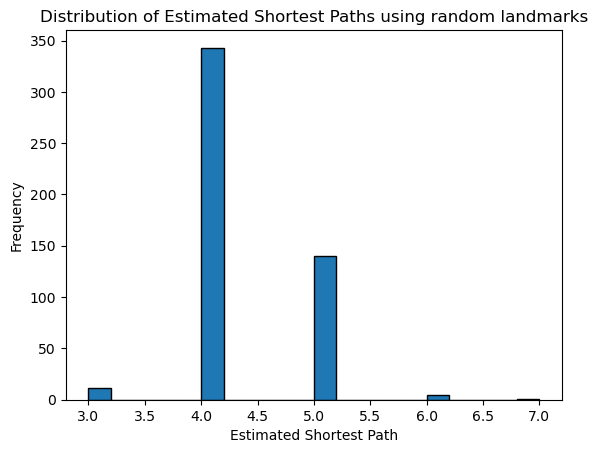

0.5801735999998404


In [47]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_twitch, num_landmarks)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))





### Degree landmarks TWITCH

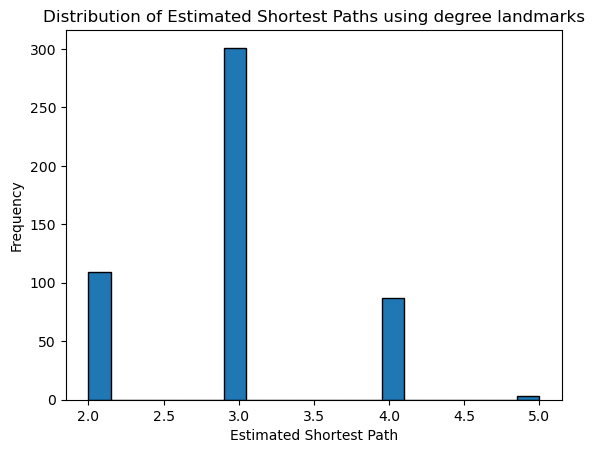

0.24833680000021738


In [48]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_twitch, num_landmarks, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness centrality landmarks TWITCH

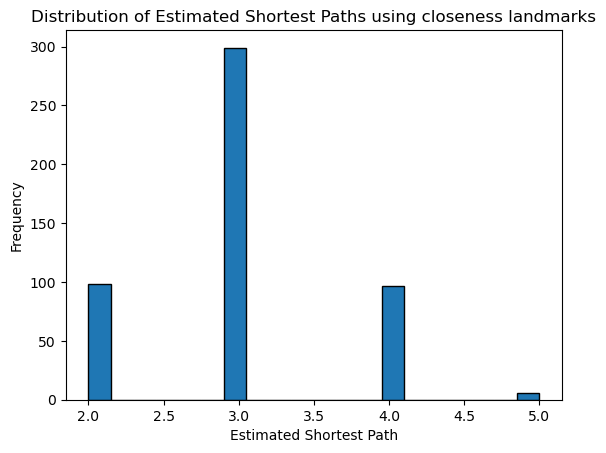

0.2562352000002212


In [49]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_twitch, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweeness landmarks TWITCH

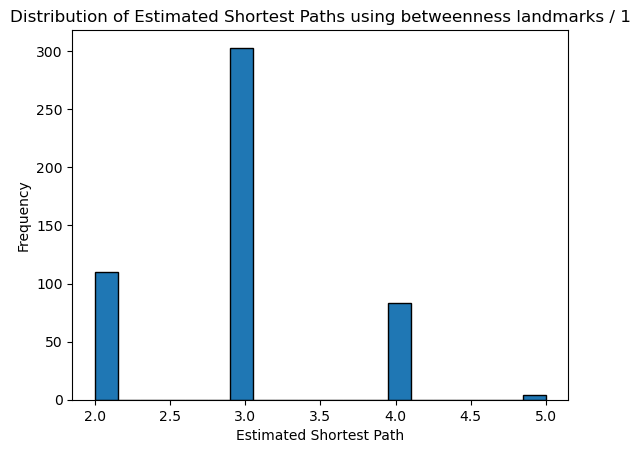

0.24744320000021103


In [50]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_twitch, num_landmarks, num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks / 1 TWITCH

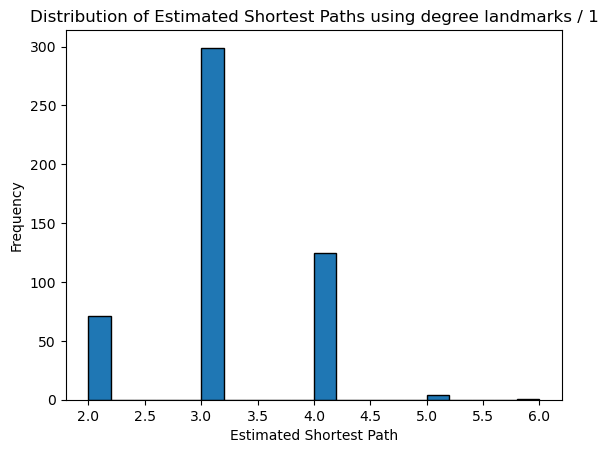

0.2672096000001995


In [51]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_twitch, num_landmarks , check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness landmarks / 1 TWITCH

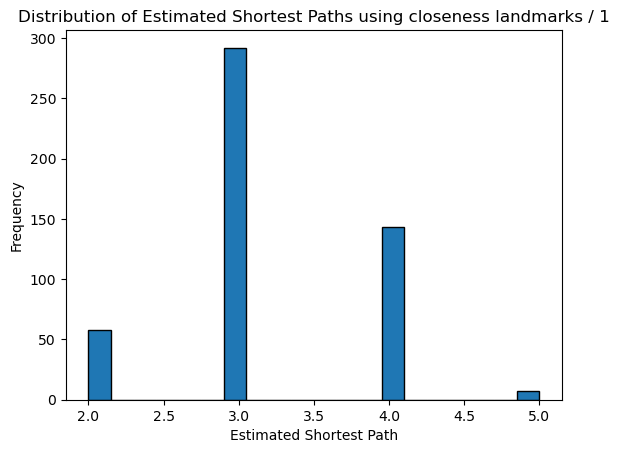

0.2775048000001252


In [52]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_twitch, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Betweenness landmarks / 1 TWITCH

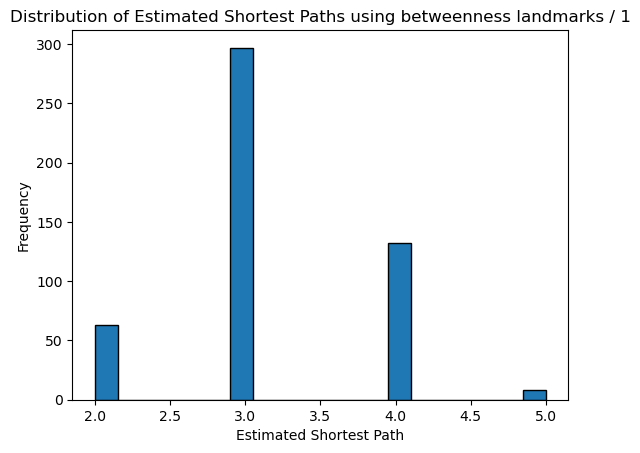

0.2731520000001604


In [53]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_twitch, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree / P TWITCH

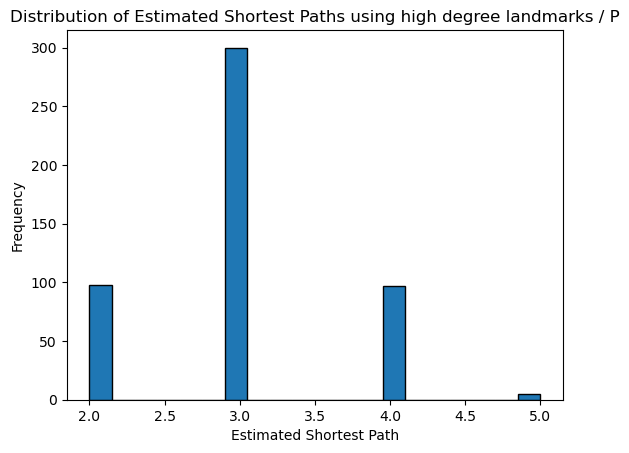

0.254888800000223


In [54]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_twitch, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Closeness / P TWITCH

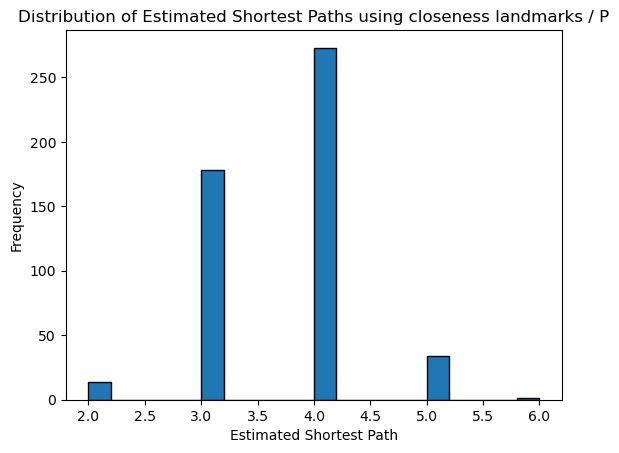

0.3863855999997628


In [55]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_twitch, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness / P TWITCH

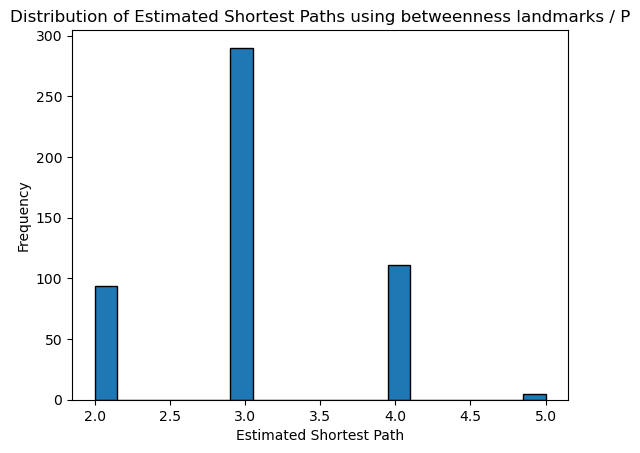

0.2626264000002404


In [56]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_twitch, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Border / P TWITCH

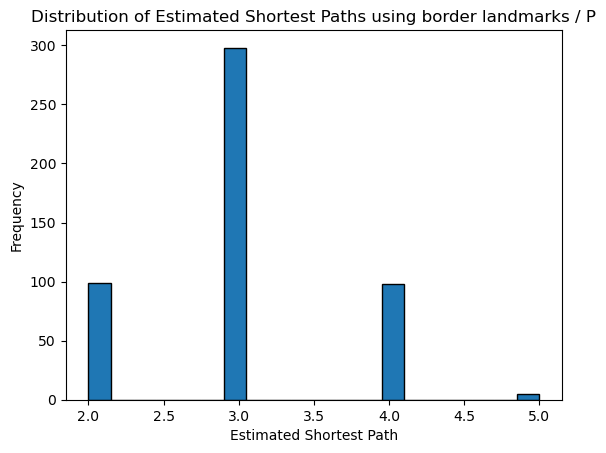

0.25570480000022416


In [57]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_twitch, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid strategy (1/3 top nodes for each strategy) Twitch

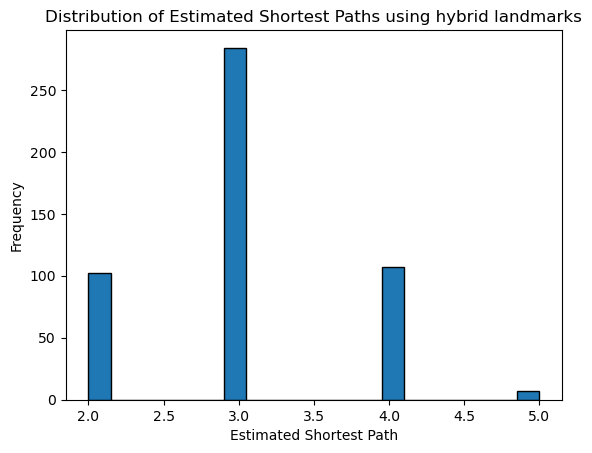

0.26451280000022764


In [58]:
hybrid_landmarks = calculate_hybrid_nodes(G_twitch, int(num_landmarks / 3)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Degree

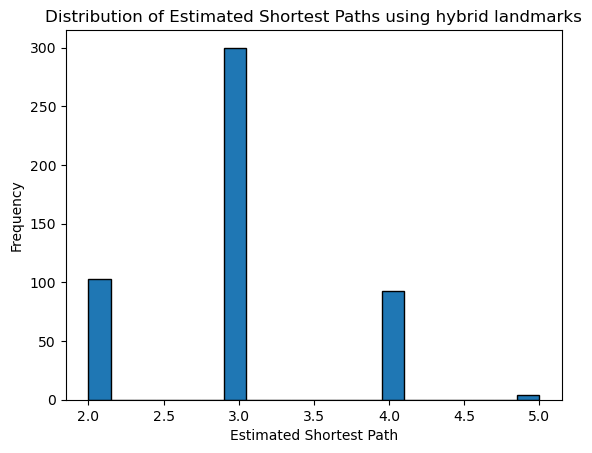

0.25212160000022554


In [59]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_degree(G_twitch, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Betweenness

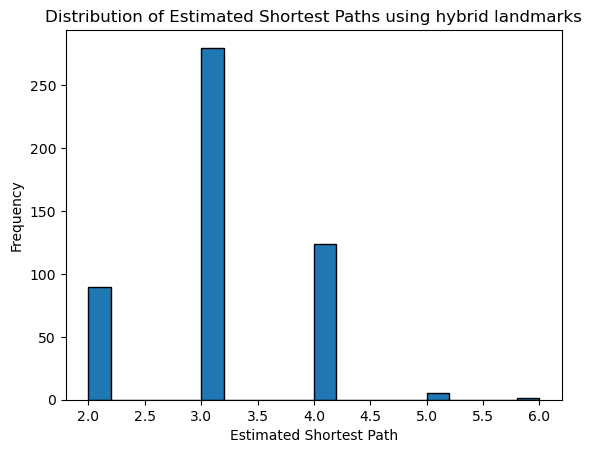

0.27183600000018965


In [60]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_betweenness(G_twitch, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Degree + Betweenness

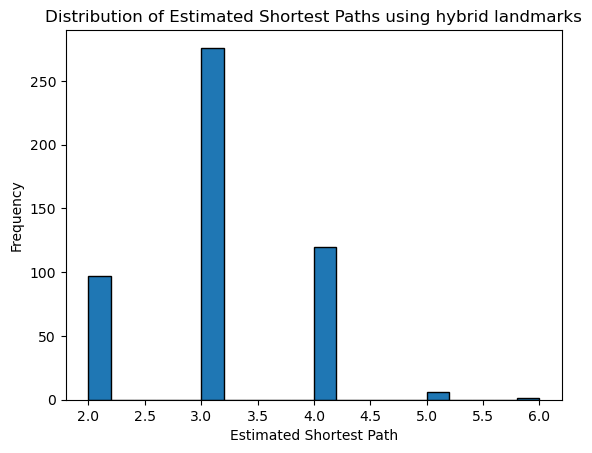

0.2721712000001844


In [61]:
hybrid_landmarks = calculate_hybrid_nodes_degree_betweenness(G_twitch, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_twitch, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

# Facebook dataset (artists)

In [62]:
# Read the CSV file into a DataFrame
file_path = 'data/facebook_clean_data/artist_edges.csv'
df = pd.read_csv(file_path)

# Initialize the graph
G_facebook = nx.Graph()

# Add edges from the DataFrame
G_facebook.add_edges_from(df.values)

# Get the number of edges and nodes
num_edges = G_facebook.number_of_edges()
num_nodes = G_facebook.number_of_nodes()

print("Number of undirected edges:", num_edges)
print("Number of undirected nodes:", num_nodes)
print(nx.is_connected(G_facebook))


Number of undirected edges: 819306
Number of undirected nodes: 50515
True


In [63]:
# Parameters for petser

num_seeds = 200
number_partitions = 102
num_landmarks = 102
random_seed = 69  

# Set the seed for the random number generator
random.seed(random_seed)
random_node_pairs = generate_random_node_pairs(G_facebook, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_facebook, number_partitions)

### Exact paths FACEBOOK

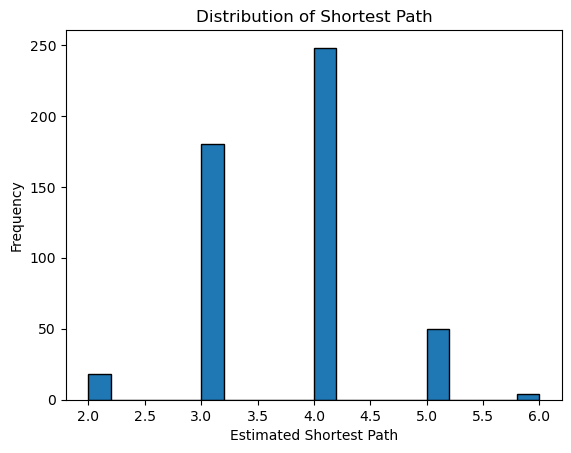

In [64]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_facebook, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())
# print(exact_shortest_paths)

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path')
plt.show()

### Random Landmarks FB

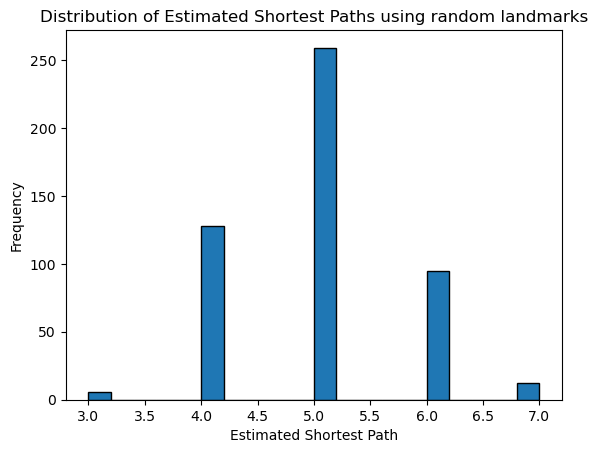

0.4217853333333822


In [65]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_facebook, num_landmarks)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))





### Degree landmarks FB

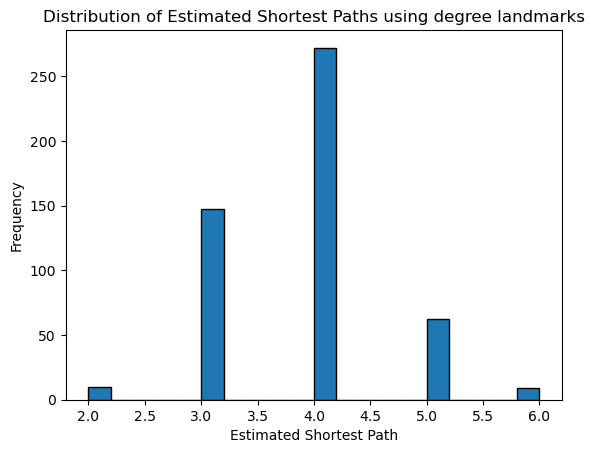

In [66]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_facebook, num_landmarks, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()


### Closeness centrality landmarks FB


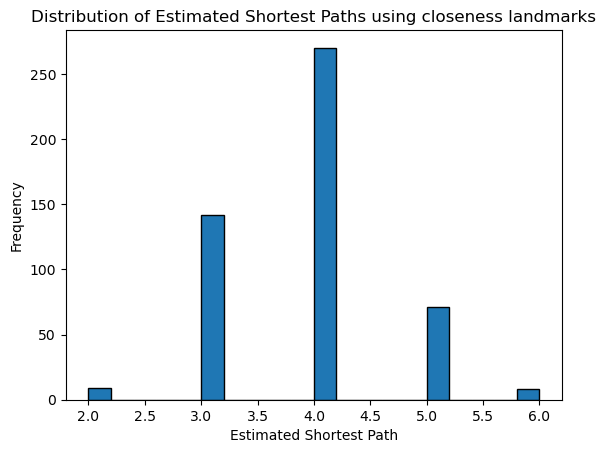

0.22784933333344684


In [67]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_facebook, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweeness landmarks FB

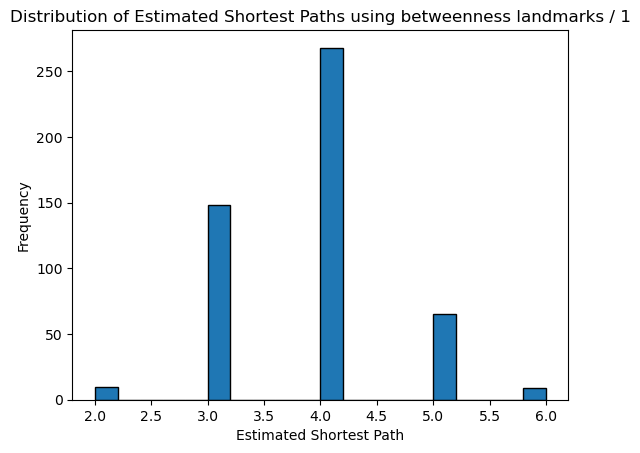

0.22660133333344745


In [68]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_facebook, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks / 1 FB

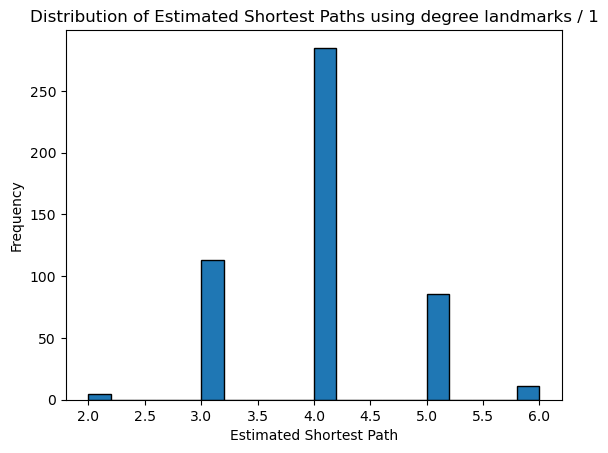

0.23573466666677495


In [69]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_facebook, num_landmarks, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness landmarks / 1 FB

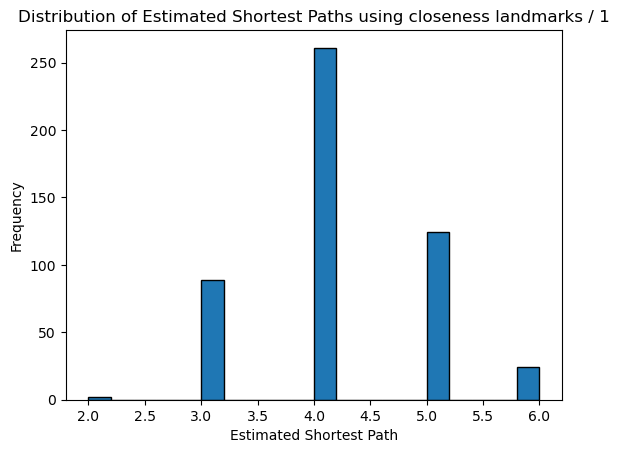

0.2657000000000475


In [70]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_facebook, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Betweenness landmarks / 1 FB

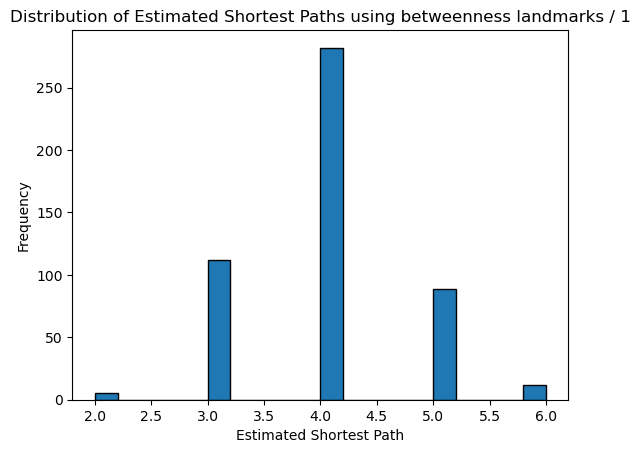

0.238206666666768


In [71]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_facebook, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree / P FB

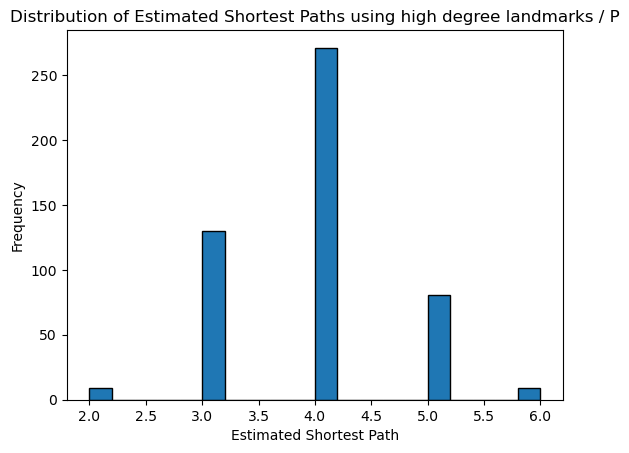

0.23352933333344245


In [72]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_facebook, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Closeness / P FB

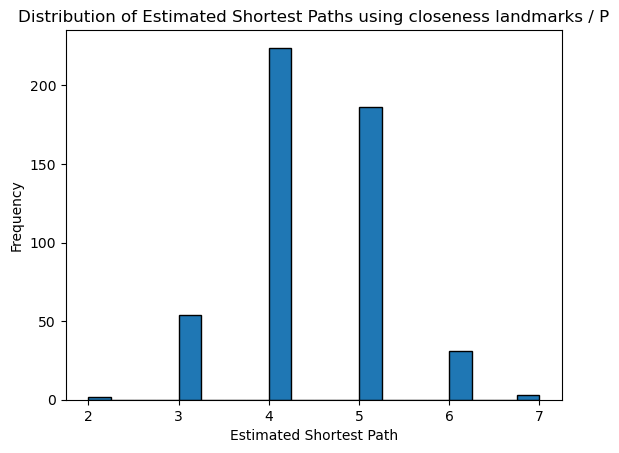

0.30715599999993654


In [73]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_facebook, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness / P FB

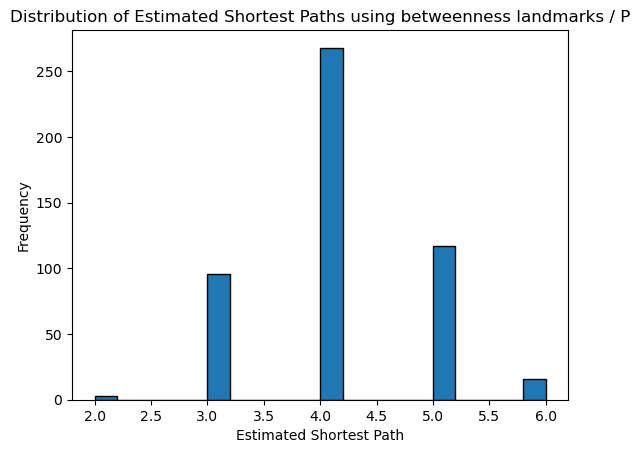

0.2546013333334031


In [74]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_facebook, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Border / P FB

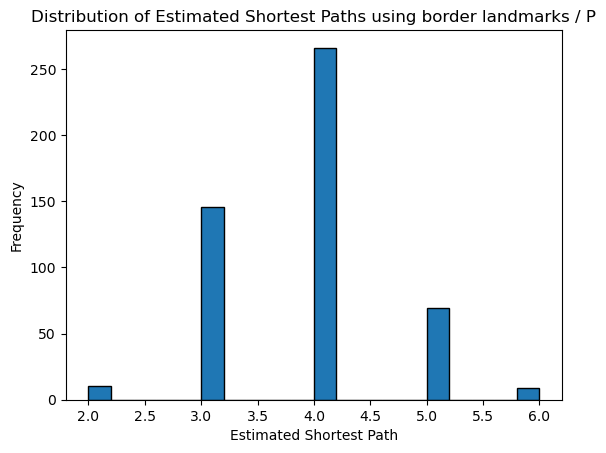

0.22849733333344757


In [75]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_facebook, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid strategy (1/3 top nodes for each strategy) FB

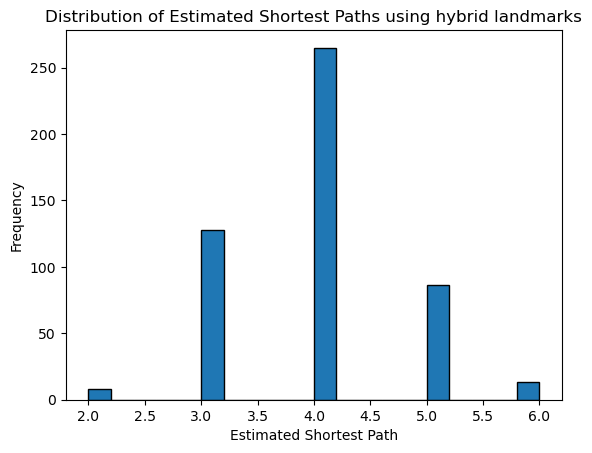

0.2395680000000992


In [76]:
hybrid_landmarks = calculate_hybrid_nodes(G_facebook, int(num_landmarks / 3)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Degree

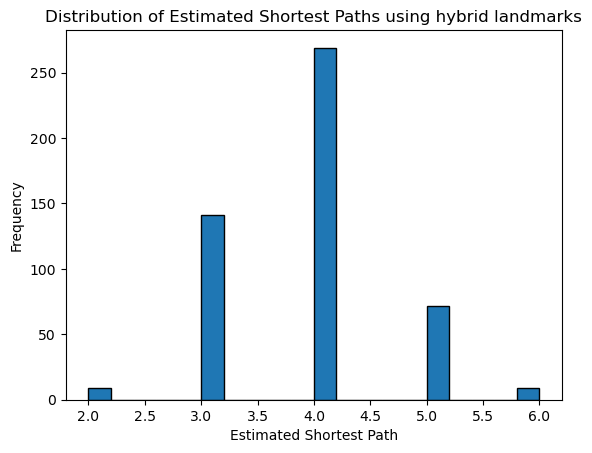

0.22935866666678115


In [77]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_degree(G_facebook, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Betweenness

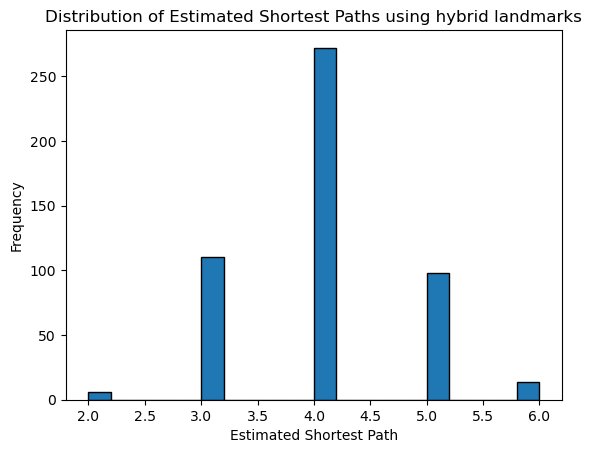

0.2451040000000882


In [78]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_betweenness(G_facebook, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Degree + Betweenness

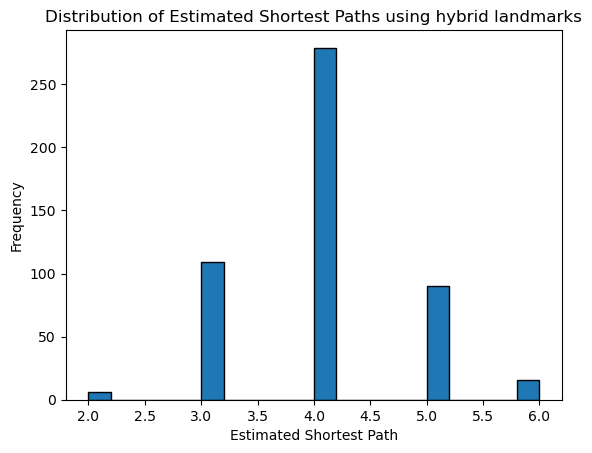

0.24332400000009746


In [79]:
hybrid_landmarks = calculate_hybrid_nodes_degree_betweenness(G_facebook, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_facebook, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

# Hyves



In [80]:
# Initialize Hyves graph
G_hyves_full = nx.DiGraph()  # Use DiGraph for directed graph

# hyves/out.tsv
file_path = 'data/hyves/out.tsv'
with open(file_path, 'r') as file:
    # Skip the header line
    next(file)
    
    for line in file:
        source, target = map(int, line.strip().split())
        G_hyves_full.add_edge(source, target)

# Find weakly connected components
weakly_connected_components = list(nx.weakly_connected_components(G_hyves_full))

# Find the Largest Weakly Connected Component (LWCC)
lwcc = max(weakly_connected_components, key=len)

# Create a subgraph for the LWCC
G_hyves = G_hyves_full.subgraph(lwcc)

# Convert the LWCC subgraph to an undirected graph
G_hyves = G_hyves.to_undirected()

# Get the number of edges and nodes in the undirected LWCC
num_lwcc_undirected_edges = G_hyves.number_of_edges()
num_lwcc_undirected_nodes = G_hyves.number_of_nodes()

print("Number of edges in undirected LWCC:", num_lwcc_undirected_edges)
print("Number of nodes in undirected LWCC:", num_lwcc_undirected_nodes)
print(nx.is_connected(G_hyves))



Number of edges in undirected LWCC: 2777419
Number of nodes in undirected LWCC: 1402673
True


In [81]:
# Parameters for hyves

num_seeds = 200
number_partitions = 102
num_landmarks = 102
random_seed = 69  

# Set the seed for the random number generator
random.seed(random_seed)
random_node_pairs = generate_random_node_pairs(G_hyves, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_hyves, number_partitions)

### Shortest exath paths

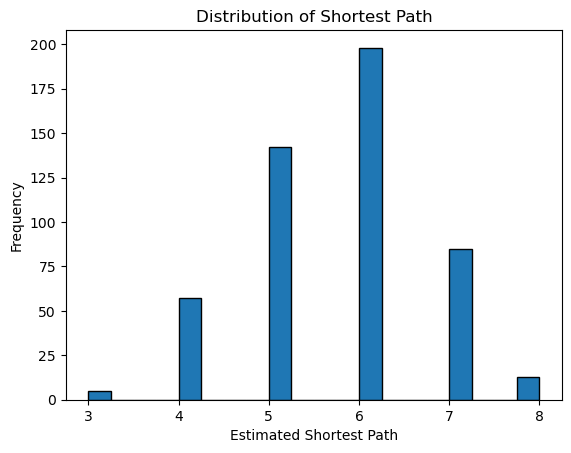

In [82]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_hyves, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())
# print(exact_shortest_paths)

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path')
plt.show()

### Random Landmarks Hyves

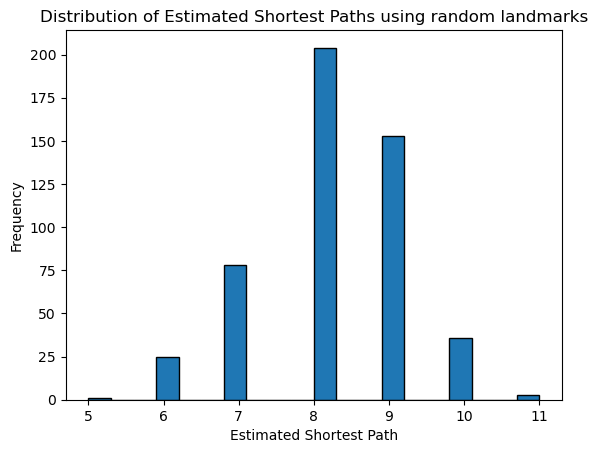

0.4994690619047858


In [83]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_hyves, num_landmarks)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))





### Degree landmarks Hyves

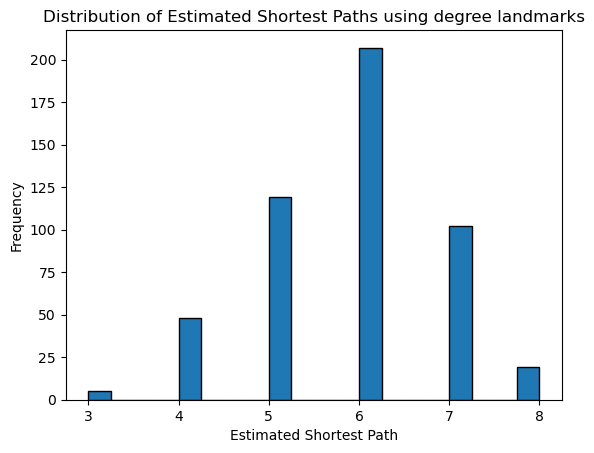

0.20802145714276016


In [84]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_hyves, num_landmarks, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness centrality landmarks Hyves


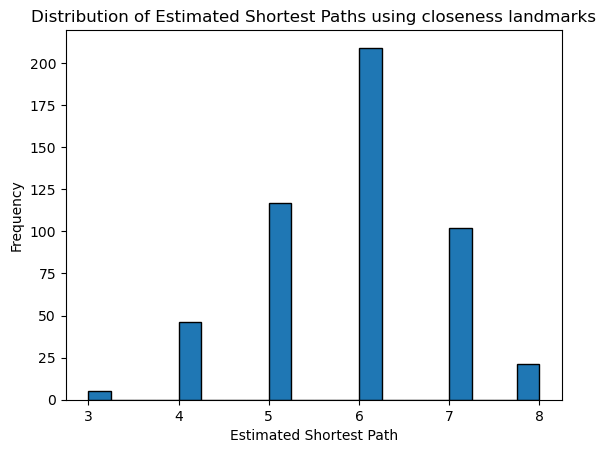

0.20871929523799418


In [85]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_hyves, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweeness landmarks Hyves

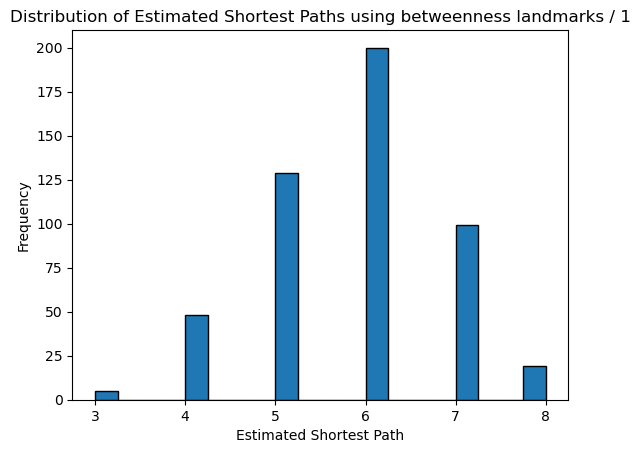

0.20735691904752393


In [86]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_hyves, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks / 1 Hyves

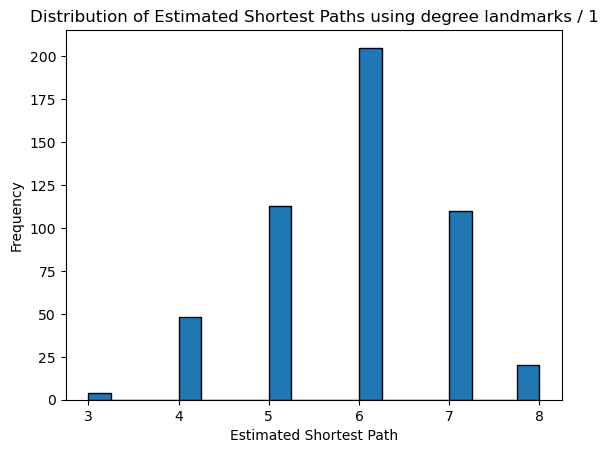

0.2100039095237071


In [87]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_hyves, num_landmarks , check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness landmarks / 1 Hyves

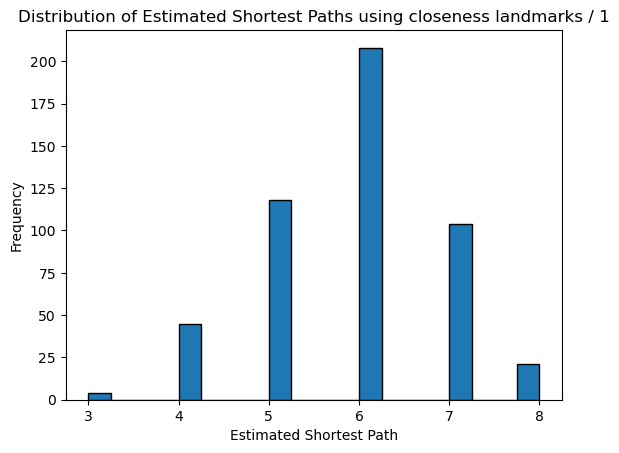

0.20839286666656723


In [88]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_hyves, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Betweenness landmarks / 1 Hyves

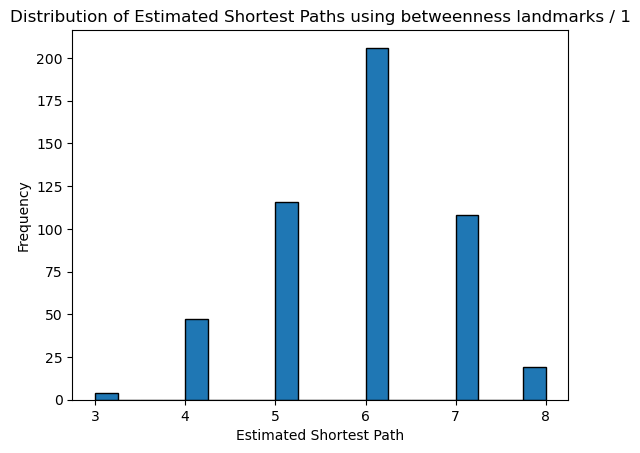

0.20867259047609266


In [89]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_hyves, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation

# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree / P Hyves

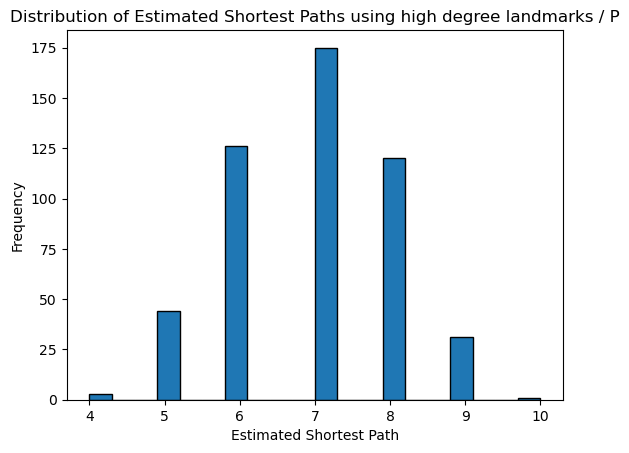

0.30430594285699064


In [90]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_hyves, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Closeness / P Hyves

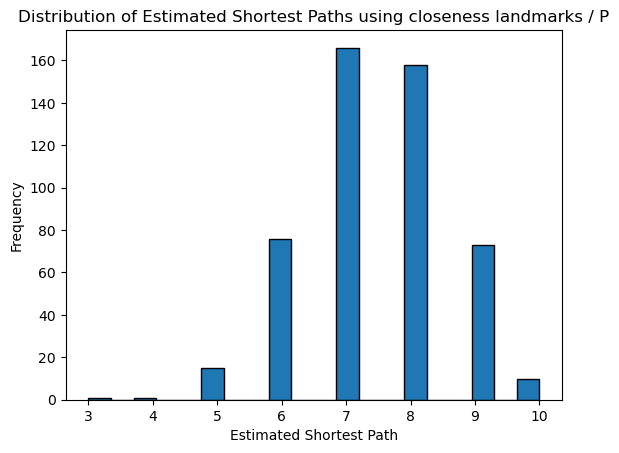

0.37759079523801037


In [91]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_hyves, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness / P Hyves

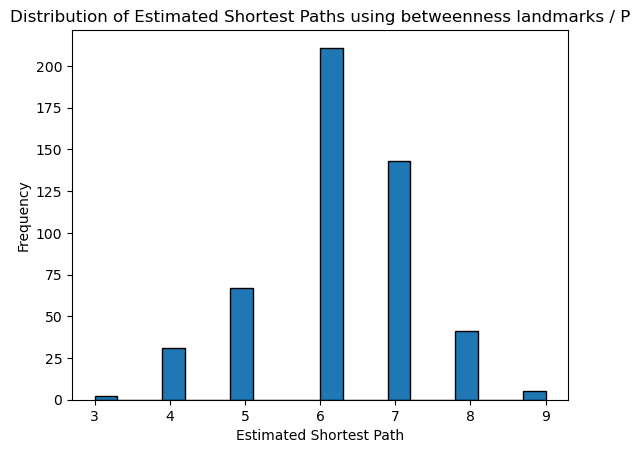

0.23011549999986522


In [92]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_hyves, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Border / P Hyves

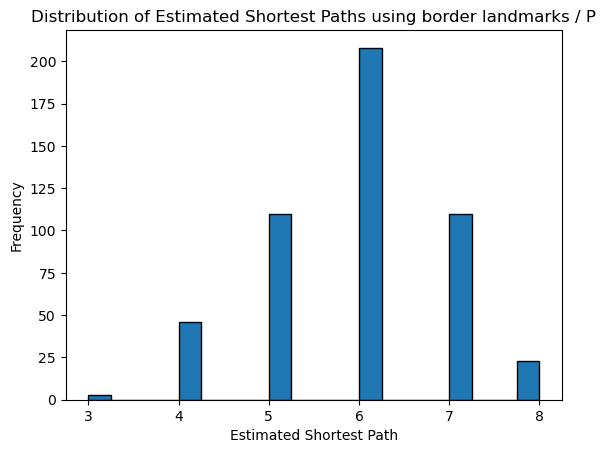

0.2106996619046526


In [93]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_hyves, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid strategy (1/3 top nodes for each strategy) Hyves

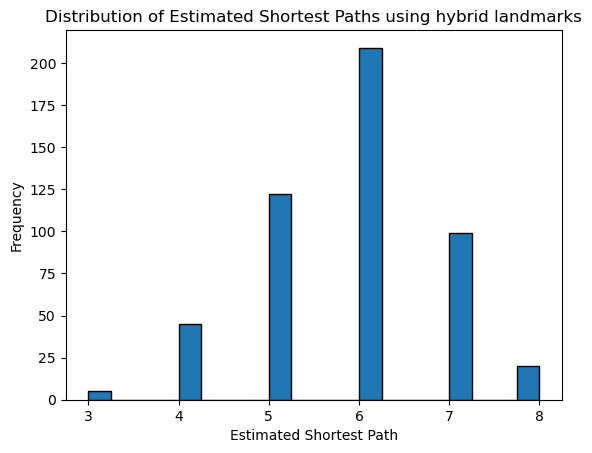

0.20715339047609083


In [94]:
hybrid_landmarks = calculate_hybrid_nodes(G_hyves, int(num_landmarks / 3)) # second parater is number of landmarks for each centrality dived by 3


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Degree

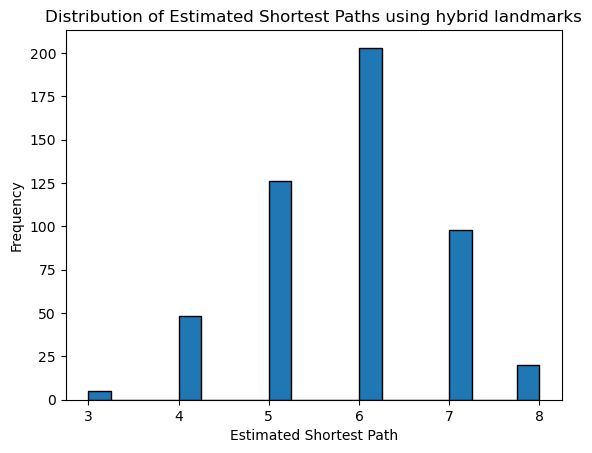

0.2076788428570465


In [95]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_degree(G_hyves, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality dived by 3


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closness + Betweenness

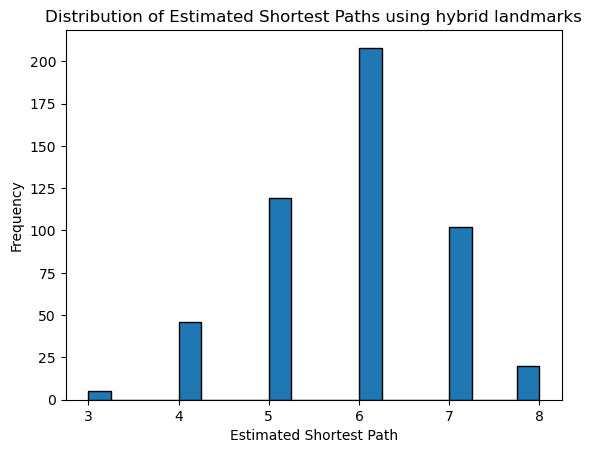

0.20813337142847313


In [96]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_betweenness(G_hyves, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality dived by 3


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Degree + Betweeness

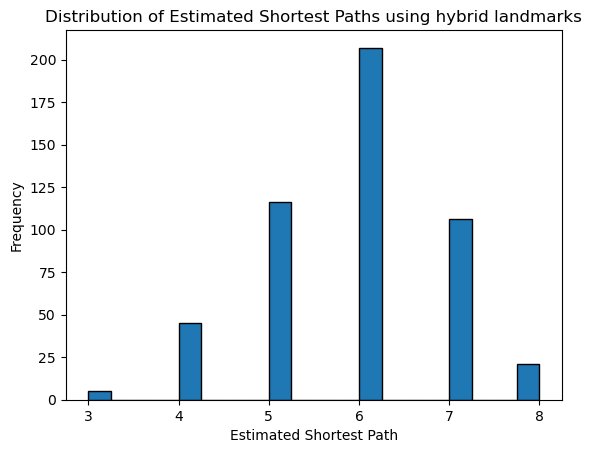

0.20947946190465894


In [97]:
hybrid_landmarks = calculate_hybrid_nodes_degree_betweenness(G_hyves, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality dived by 3


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_hyves, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

# Petser - cats

In [98]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize Hyves graph
G_petser_full = nx.DiGraph()  # Use DiGraph for directed graph

# hyves/out.tsv
file_path = 'data/petster-friendships-cat/out.tsv'
with open(file_path, 'r') as file:
    # Skip the header line
    next(file)
    
    for line in file:
        source, target = map(int, line.strip().split())
        G_petser_full.add_edge(source, target)

# Find weakly connected components
weakly_connected_components = list(nx.weakly_connected_components(G_petser_full))

# Find the Largest Weakly Connected Component (LWCC)
lwcc = max(weakly_connected_components, key=len)

# Create a subgraph for the LWCC
G_petser = G_petser_full.subgraph(lwcc)

# Convert the LWCC subgraph to an undirected graph
G_petser = G_petser.to_undirected()

# Get the number of edges and nodes in the undirected LWCC
num_lwcc_undirected_edges = G_petser.number_of_edges()
num_lwcc_undirected_nodes = G_petser.number_of_nodes()

print("Number of edges in undirected LWCC:", num_lwcc_undirected_edges)
print("Number of nodes in undirected LWCC:", num_lwcc_undirected_nodes)
print(nx.is_connected(G_petser))



Number of edges in undirected LWCC: 5448486
Number of nodes in undirected LWCC: 148826
True


In [99]:
# Parameters for petser

num_seeds = 200
number_partitions = 102
num_landmarks = 102
random_seed = 69  

# Set the seed for the random number generator
random.seed(random_seed)

random_node_pairs = generate_random_node_pairs(G_petser, number_pairs=500)
partition_sets, edge_cut = partition_graph_func(G_petser, number_partitions)

### Shortest exacth paths Petser

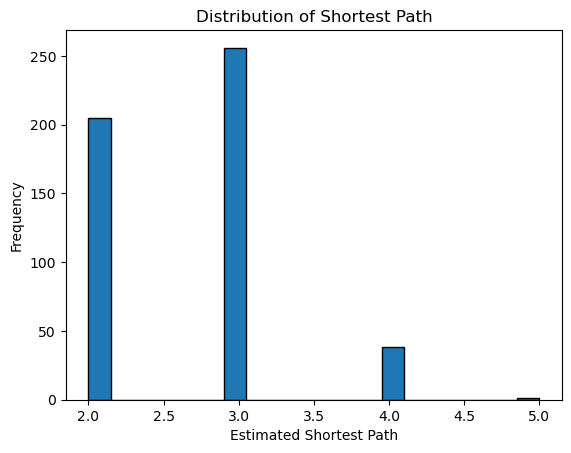

In [100]:
exact_shortest_paths = {}

for pair in random_node_pairs:
    source, target = pair
    shortest_path_distance = calculate_exact_shortest_path(G_petser, source, target)
    exact_shortest_paths[pair] = shortest_path_distance

exact_shortest_paths


# Get the list of estimated shortest paths
estimations = list(exact_shortest_paths.values())
# print(exact_shortest_paths)

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Shortest Path')
plt.show()

### Random Landmarks Petser

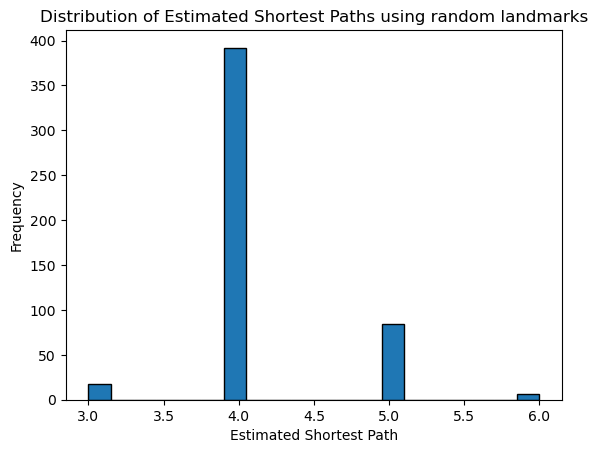

0.6439498666668165


In [101]:
# Workflow:
# Select landmarks
# Generate 500 random pairs of nodes
# Calculate shortest paths between each pair using landmarks

# Select landmarks
random_landmarks = generate_rng_landmark_list(G_petser, num_landmarks)

# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, random_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using random landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks Petser

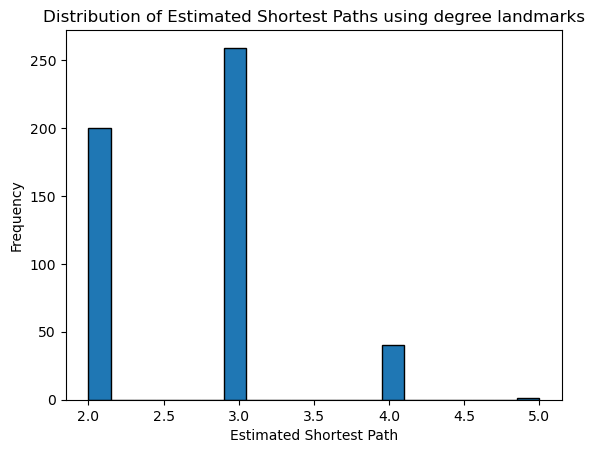

0.24882906666687993


In [102]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_petser, num_landmarks, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness centrality landmarks Petser


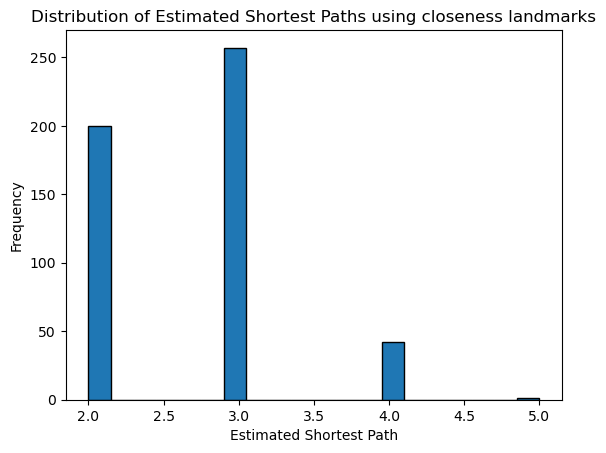

0.2502541333335501


In [103]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_petser, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweeness landmarks Petser

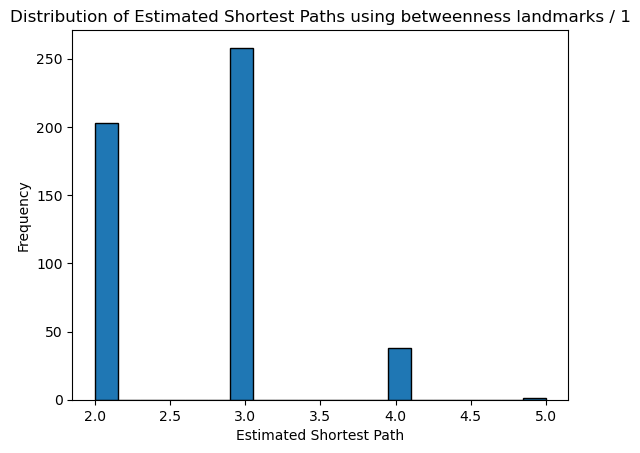

0.24731440000021063


In [104]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_petser, num_landmarks , num_seeds, check_neighbors=False)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree landmarks / 1 Petser

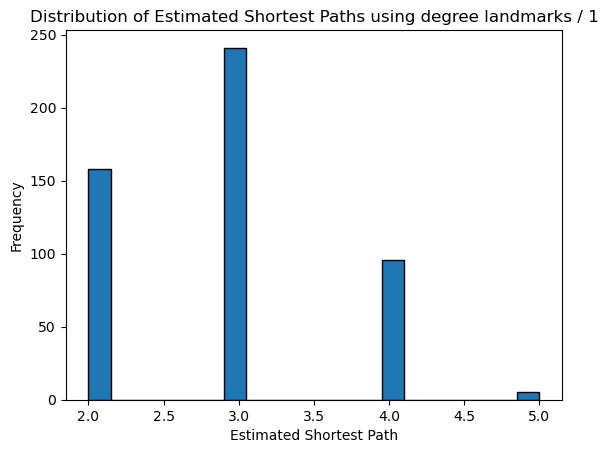

0.29598960000004887


In [105]:
# Select landmarks
degree_landmarks = calculate_degree_centrality(G_petser, num_landmarks , check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, degree_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using degree landmarks / 1')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Closeness landmarks / 1 Petser

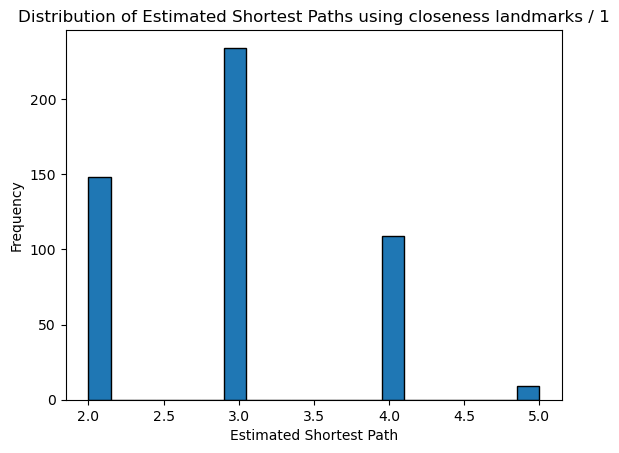

0.3115554666666526


In [106]:
# Select landmarks
closeness_landmarks = calculate_closeness_centrality(G_petser, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, closeness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Betweenness landmarks / 1 Petser

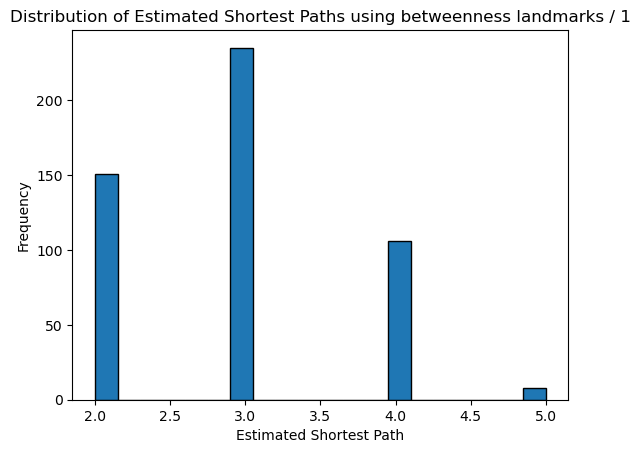

0.30782720000000263


In [107]:
# Select landmarks
betweenness_landmarks = calculate_betweenness_centrality(G_petser, num_landmarks , num_seeds, check_neighbors=True)


# Calculate estimation of shortest paths between each pair using landmarks

estimated_shortest_paths = {}

# Calculate estimation of shortest paths between each pair using landmarks
for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, betweenness_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / 1')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Degree / P Petser

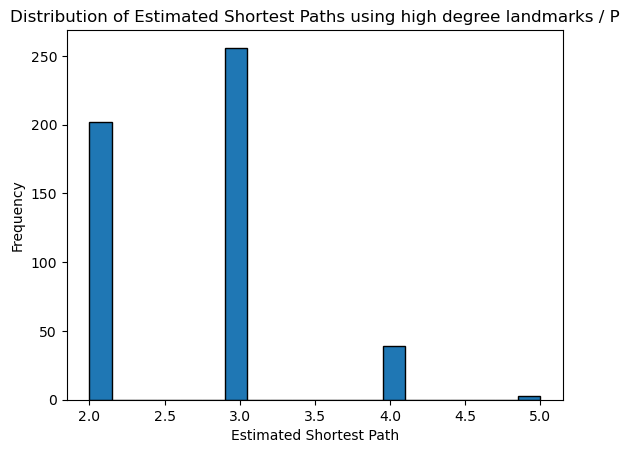

0.2510589333335481


In [108]:
# Initialize dictionaries to store results
degree_centralities = {} 
estimated_shortest_paths = {}
estimations = {}

# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_petser, partition)
    degree_centrality = calculate_degree_centrality(partition_graph, N=1, check_neighbors=False)

    degree_centralities.update(degree_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, degree_centralities)
    estimated_shortest_paths[(source, target)] = estimation


estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using high degree landmarks / P')
plt.show()
print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))


### Closeness / P Petser

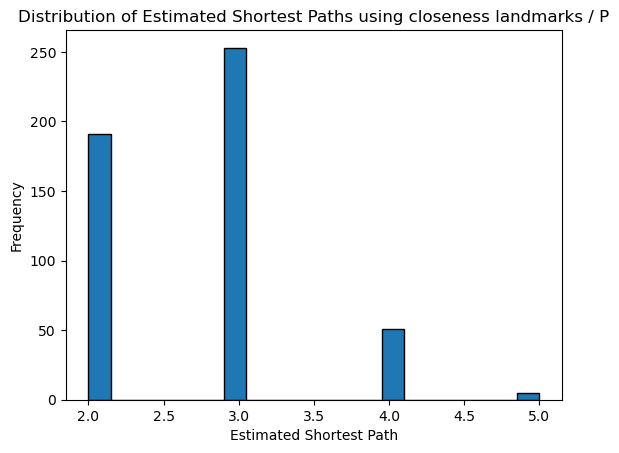

0.26294000000022016


In [109]:
# Initialize dictionaries to store results
closeness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_petser, partition)
    closeness_centrality = calculate_closeness_centrality(partition_graph, N=1, check_neighbors=False)

    closeness_centralities.update(closeness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, closeness_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using closeness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Betweenness / P Petser

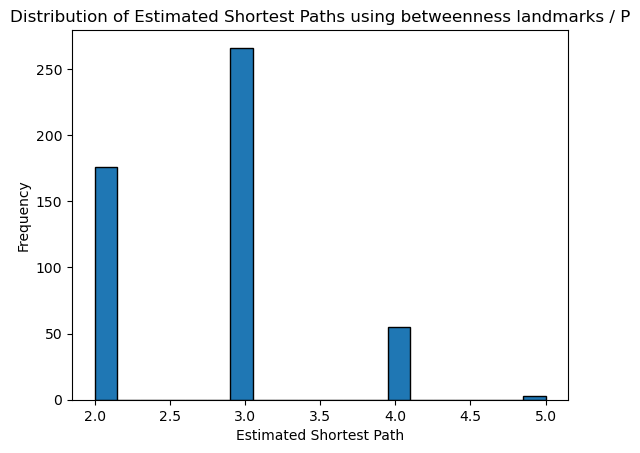

0.26323600000020453


In [110]:
# Initialize dictionaries to store results
betweenness_centralities = {} 
estimated_shortest_paths = {}
estimations = {}


# For each partition
for i, partition in enumerate(partition_sets):
    partition_graph = nx.subgraph(G_petser, partition)
    betweenness_centrality = calculate_betweenness_centrality(partition_graph, N=1, check_neighbors=False)

    betweenness_centralities.update(betweenness_centrality)  

# print(degree_centralities)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, betweenness_centralities)
    estimated_shortest_paths[(source, target)] = estimation

estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using betweenness landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Border / P Petser

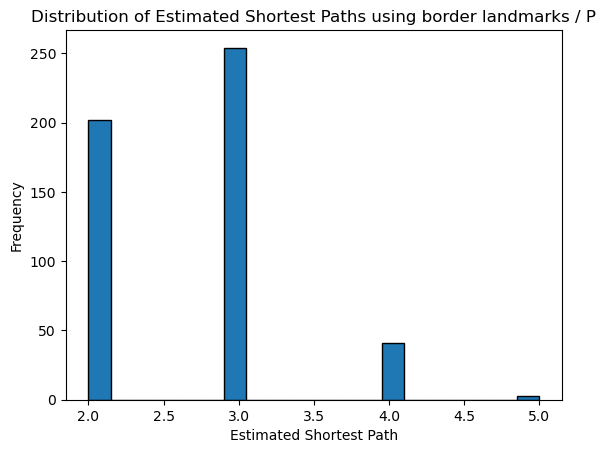

0.25248400000021914


In [111]:
# Border landmarks in partitions
border_landmarks = get_highest_degree_nodes_border(G_petser, number_partitions)

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, border_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using border landmarks / P')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid strategy (1/3 top nodes for each strategy) Petser

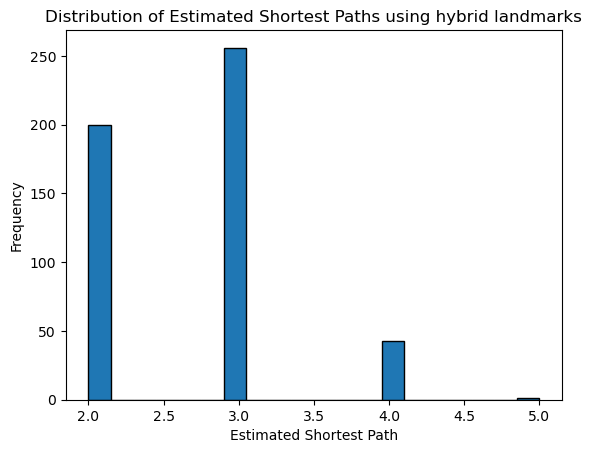

0.2509666666668853


In [112]:
hybrid_landmarks = calculate_hybrid_nodes(G_petser, int(num_landmarks / 3)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Degree

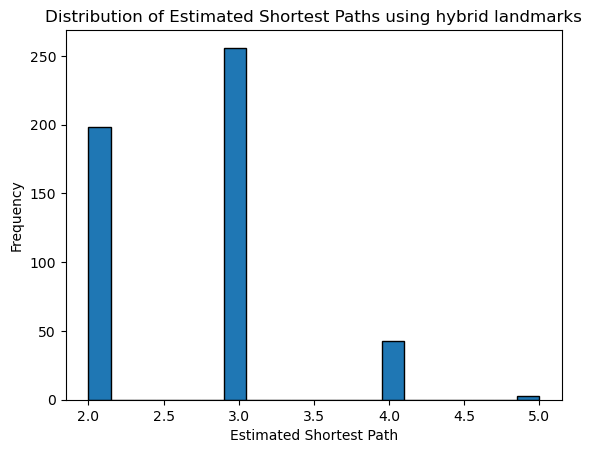

0.25402853333355435


In [113]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_degree(G_petser, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid 50/50 Closeness + Betweenness

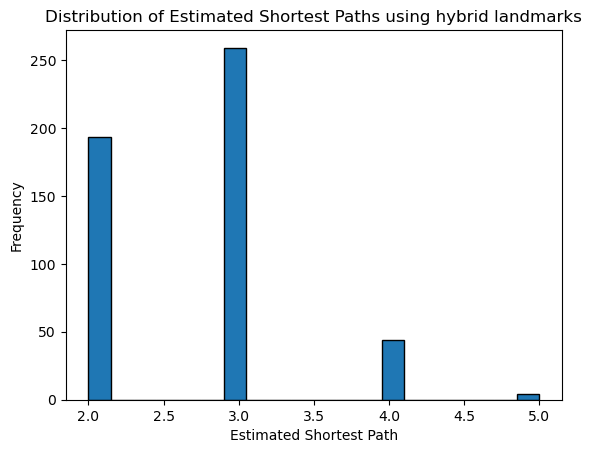

0.25639146666688145


In [114]:
hybrid_landmarks = calculate_hybrid_nodes_closeness_betweenness(G_petser, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))

### Hybrid Degree + Betweenness

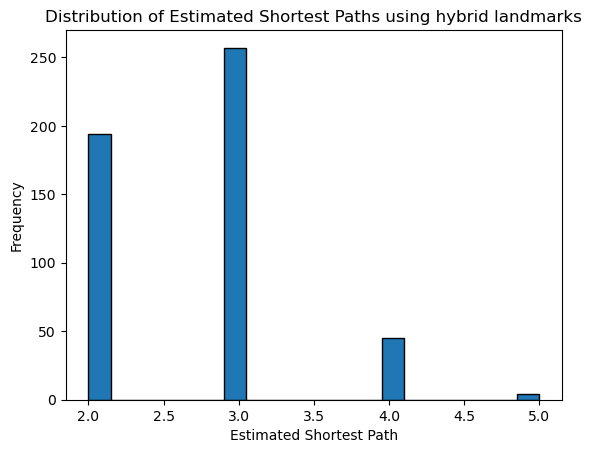

0.25707413333354995


In [115]:
hybrid_landmarks = calculate_hybrid_nodes_degree_betweenness(G_petser, int(num_landmarks / 2)) # second parater is number of landmarks for each centrality


estimated_shortest_paths = {}

for source, target in random_node_pairs:
    estimation = estimate_shortest_path(G_petser, source, target, hybrid_landmarks)
    estimated_shortest_paths[(source, target)] = estimation


# Get the list of estimated shortest paths
estimations = list(estimated_shortest_paths.values())

# Plot the distribution
plt.hist(estimations, bins=20, edgecolor='black')
plt.xlabel('Estimated Shortest Path')
plt.ylabel('Frequency')
plt.title('Distribution of Estimated Shortest Paths using hybrid landmarks')
plt.show()

print(diff_exact_estimate(exact_shortest_paths,estimated_shortest_paths))